# Libraries & Global variables

In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import cv2
import json
import joblib

import os
import time

%load_ext autoreload
%autoreload 2
import importlib

import VGG_model_tools as vggt
importlib.reload(vggt)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'VGG_model_tools' from 'C:\\Ramiro\\Data Science\\0_DataScientest\\02_DS_project\\Raku_ten_23\\VGG_model_tools.py'>

In [48]:
## define general parameters

myseed = 123

splitting_path = '../Splitted_datasets/'
# preprocessing_path = '../Preprocessed_data/'
# training_path = '../Trained_models_and_metrics/'
# base_img_path = '../Base_models/Image/'

#### product categories

In [42]:
product_class = pd.read_csv('../datasets/product_class.csv', sep = ';')
product_class.drop('target', axis = 1, inplace = True)
print(product_class.shape)
product_class

(27, 2)


,prdtypecode,prodtype
0,10,livres_adulte
1,40,jeux_videos_import
2,50,accessoires_jeux_videos
3,60,jeux_et_consoles_retro
4,1140,goodies_geek
5,1160,cartes_a_jouer
6,1180,figurines_wargames
7,1280,jouets_enfance
8,1281,jeux_societe
9,1300,modeles_reduits_ou_telecommandes


# Get data with flow_from_directory

**Instantiate Image Data Generators: No data augmentation, just pixel scaling**

In [7]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rescale = 1./255)

val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rescale = 1./255)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rescale = 1./255)

**Define dataset generators with flow_from_directory() for headless model**

In [8]:
t0 = time.time()

batch_size = 64

## for flow_from_directory() method:
train_dataset = train_datagen.flow_from_directory( directory = '../Splitted_datasets/Images_224px/Train_subset',
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = batch_size,
                                                   class_mode = None,   # for the model to return just features, no predictions.
                                                   shuffle = False,     # to be able to identify the image featured
                                                   seed = myseed)

val_dataset = val_datagen.flow_from_directory( directory = '../Splitted_datasets/Images_224px/Validation_subset',
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = batch_size,
                                                   class_mode = None,  # same as for train set
                                                   shuffle = False,    # same as for train set
                                                   seed = myseed) 

test_dataset = test_datagen.flow_from_directory( directory = '../Splitted_datasets/Images_224px/Test_subset',
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 1,
                                                   class_mode = None,  # same as for train set
                                                   shuffle = False,    # same as for train set
                                                   seed = myseed)


t1 = time.time()
print("dataset generator with flow() method takes %0.2f seconds" %(t1-t0))

Found 54345 images belonging to 27 classes.
Found 13587 images belonging to 27 classes.
Found 16984 images belonging to 1 classes.
dataset generator with flow() method takes 6.08 seconds


# VGG headless model

**Feature extraction layers - Pretrained layers**

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16

# get pre-rained VGG16 layers
headless_VGG = VGG16(weights = 'imagenet', include_top = False)

# freeze layers
for layer in headless_VGG.layers:
    layer.trainable = False


In [10]:
headless_VGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Predictions**

In [14]:
## Do predictions. Reset the data generator before predicting.

train_dataset.reset()  
output_vector_train = headless_VGG.predict(train_dataset)
print("output_vector_train :", output_vector_train.shape)

val_dataset.reset()  
output_vector_val = headless_VGG.predict(val_dataset)
print("output_vector_val :", output_vector_val.shape)

test_dataset.reset()  
output_vector_test = headless_VGG.predict(test_dataset)
print("output_vector_test :", output_vector_test.shape)


850/850 [==============================] - 4613s 5s/step
output_vector_train : (54345, 7, 7, 512)
213/213 [==============================] - 1217s 6s/step
output_vector_val : (13587, 7, 7, 512)
16984/16984 [==============================] - 2095s 123ms/step
output_vector_test : (16984, 7, 7, 512)


In [17]:
print(output_vector_train.shape)   # like a very deep image
print(output_vector_val.shape)
print(output_vector_test.shape)

(54345, 7, 7, 512)
(13587, 7, 7, 512)
(16984, 7, 7, 512)


**Identify the product id on the order as processed y the predict method**  
This is important to link avery output vector from the headless model with a row in the dataframes containing the true classes and other informations.

In [94]:
# X_train_subset = pd.read_csv('../Splitted_datasets/2308242016_df_X_train_subset.csv', header = 0, index_col = 0)
y_train_subset = pd.read_csv('../Splitted_datasets/2308242016_df_y_train_subset.csv', header = 0, index_col = 0)
# X_val_subset = pd.read_csv('../Splitted_datasets/2308242016_df_X_val_subset.csv', header = 0, index_col = 0)
# y_val_subset = pd.read_csv('../Splitted_datasets/2308242016_df_y_val_subset.csv', header = 0, index_col = 0)
# X_test_subset = pd.read_csv('../Splitted_datasets/2308141811_df_X_test.csv', header = 0, index_col = 0)
# y_test_subset = pd.read_csv('../Splitted_datasets/2308141811_df_y_test.csv', header = 0, index_col = 0)

In [52]:
train_sorted_items = vggt.get_items_by_processing_order(train_dataset, X_train_subset, y_train_subset)
val_sorted_items = vggt.get_items_by_processing_order(val_dataset, X_val_subset, y_val_subset)
test_sorted_items = vggt.get_items_by_processing_order(test_dataset, X_test_subset, y_test_subset)

In [53]:
## quick verifycation case:
display(val_sorted_items.iloc[495:505,:])
display(val_dataset.filenames[495:505])

,prdtypecode,imageid,productid
84175,10,999090548,19015533
45935,10,999101884,86972217
34267,10,99936530,390718
49556,10,999988537,351615005
44003,1140,1003843085,390340055
55884,1140,1005492064,412804145
19939,1140,1006435221,424894381
14637,1140,1006740921,427835111
72319,1140,1011671634,453085631
5948,1140,1011687162,340428970


['10\\image_999090548_product_19015533.jpg',
 '10\\image_999101884_product_86972217.jpg',
 '10\\image_99936530_product_390718.jpg',
 '10\\image_999988537_product_351615005.jpg',
 '1140\\image_1003843085_product_390340055.jpg',
 '1140\\image_1005492064_product_412804145.jpg',
 '1140\\image_1006435221_product_424894381.jpg',
 '1140\\image_1006740921_product_427835111.jpg',
 '1140\\image_1011671634_product_453085631.jpg',
 '1140\\image_1011687162_product_340428970.jpg']

**save output vectors and dataframes with sorted items**

In [54]:
vggt.save(datasets = [output_vector_train, output_vector_val, output_vector_test], 
             types = ['array']*3, 
             names = ['hlVGG_output_vector_train', 'hlVGG_output_vector_val', 'hlVGG_output_vector_test'],  
              path = '../Splitted_datasets/Images_224px/', 
              doit = True, verbose = True)


vggt.save(datasets = [train_sorted_items, val_sorted_items, test_sorted_items], 
             types = ['dataframe']*3, 
             names = ['train_sorted_items_as_processed', 'val_sorted_items_as_processed', 'test_sorted_items_as_processed'],  
              path = '../Splitted_datasets/Images_224px/', 
              doit = True, verbose = True)

Saved dataset: ../Splitted_datasets/Images_224px/2308252235_hlVGG_output_vector_train.npy
Saved dataset: ../Splitted_datasets/Images_224px/2308252235_hlVGG_output_vector_val.npy
Saved dataset: ../Splitted_datasets/Images_224px/2308252235_hlVGG_output_vector_test.npy
Saved dataset: ../Splitted_datasets/Images_224px/2308252236_train_sorted_items_as_processed.csv
Saved dataset: ../Splitted_datasets/Images_224px/2308252236_val_sorted_items_as_processed.csv
Saved dataset: ../Splitted_datasets/Images_224px/2308252236_test_sorted_items_as_processed.csv


**reload output vectors** (optional)

In [5]:
reload = True
if reload:
    
    path = '../Splitted_datasets/Images_224px/'
    
    output_vector_train = np.load(path + '2308252235_hlVGG_output_vector_train.npy')
    output_vector_val = np.load(path + '2308252235_hlVGG_output_vector_val.npy')
    output_vector_test = np.load(path + '2308252235_hlVGG_output_vector_test.npy')
    
    train_sorted_items = pd.read_csv(path + '2308252236_train_sorted_items_as_processed.csv', header = 0, index_col = 0)
    val_sorted_items = pd.read_csv(path + '2308252236_val_sorted_items_as_processed.csv', header = 0, index_col = 0)
    test_sorted_items = pd.read_csv(path + '2308252236_test_sorted_items_as_processed.csv', header = 0, index_col = 0)

# Head model: fully connected layers

**One hot encode targets variables**

In [6]:
yy_train, yy_val, yy_test, target_encoder = vggt.transform_target(train_sorted_items['prdtypecode'],
                                                             val_sorted_items['prdtypecode'],
                                                             test_sorted_items['prdtypecode'])

**Define head model**

In [139]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential

Nb_classes = 27

head_model = Sequential()
# ##>>> batch normalization layer ? before Dropout
head_model.add(GlobalAveragePooling2D(input_shape = output_vector_train.shape[1:]))

head_model.add( Flatten() )
# head_model.add( Flatten(input_shape = output_vector_train.shape[1:]) )
head_model.add( Dropout(rate = 0.2) )

head_model.add( Dense(units = 512, activation = 'relu') )

head_model.add( Dropout(rate = 0.2) )

head_model.add( Dense(units = 256, activation = 'relu') )

head_model.add( Dropout(rate = 0.2) )

head_model.add( Dense(units = Nb_classes, activation='softmax') )


In [140]:
head_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                      

**Define callback to use**

In [143]:
Nb_epochs = 300  # Nb of epoch for training
lr_0 = 0.4e-3     # intial learning rate

In [144]:
checkpoint_filepath = './tmp_checkpoint/img_baseModel_vgg_refined/'

callbacks = vggt.get_callbacks(checkpoint_filepath)

**Compile model**

In [145]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate = lr_0)

head_model.compile(loss = 'categorical_crossentropy',  # because targets are one hot encoded
                  optimizer = optimizer,
                  metrics = ['accuracy'])

**Train model**

In [146]:
t0 = time.time()

history = head_model.fit(output_vector_train, yy_train,
                              validation_data = (output_vector_val, yy_val),
                              epochs = Nb_epochs,
                              batch_size = 400,
                              callbacks = callbacks)

t1 = time.time()
print("For %d observations, training time = %0.2f seconds" %(output_vector_train[0], (t1-t0) ) )

head_model.load_weights(checkpoint_filepath)

model_date_time = vggt.date_time()
print("Model Training tempstamp", model_date_time)

Epoch 1/300
136/136 [==============================] - ETA: 0s - loss: 2.6365 - accuracy: 0.2397
Epoch 1: val_accuracy improved from -inf to 0.37852, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined\
136/136 [==============================] - 12s 79ms/step - loss: 2.6365 - accuracy: 0.2397 - val_loss: 2.1476 - val_accuracy: 0.3785 - lr: 4.0000e-04
Epoch 2/300
135/136 [============================>.] - ETA: 0s - loss: 2.1913 - accuracy: 0.3548
Epoch 2: val_accuracy improved from 0.37852 to 0.41724, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined\
136/136 [==============================] - 4s 27ms/step - loss: 2.1909 - accuracy: 0.3549 - val_loss: 1.9790 - val_accuracy: 0.4172 - lr: 4.0000e-04
Epoch 3/300
136/136 [==============================] - ETA: 0s - loss: 2.0699 - accuracy: 0.3856
Epoch 3: val_accuracy improved from 0.41724 to 0.44042, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined\
136/136 [==============================] - 3s 22ms/step - loss: 2

Epoch 49/300
134/136 [============================>.] - ETA: 0s - loss: 1.4293 - accuracy: 0.5589
Epoch 49: val_accuracy improved from 0.56458 to 0.56606, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined\
136/136 [==============================] - 3s 20ms/step - loss: 1.4296 - accuracy: 0.5589 - val_loss: 1.4378 - val_accuracy: 0.5661 - lr: 4.0000e-04
Epoch 50/300
133/136 [============================>.] - ETA: 0s - loss: 1.4265 - accuracy: 0.5636
Epoch 50: val_accuracy did not improve from 0.56606
136/136 [==============================] - 3s 19ms/step - loss: 1.4267 - accuracy: 0.5635 - val_loss: 1.4365 - val_accuracy: 0.5650 - lr: 4.0000e-04
Epoch 51/300
134/136 [============================>.] - ETA: 0s - loss: 1.4174 - accuracy: 0.5618
Epoch 51: val_accuracy improved from 0.56606 to 0.56834, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined\
136/136 [==============================] - 3s 20ms/step - loss: 1.4177 - accuracy: 0.5618 - val_loss: 1.4373 - val_accurac

133/136 [============================>.] - ETA: 0s - loss: 1.2083 - accuracy: 0.6191
Epoch 99: val_accuracy did not improve from 0.58622
136/136 [==============================] - 3s 20ms/step - loss: 1.2096 - accuracy: 0.6188 - val_loss: 1.3832 - val_accuracy: 0.5835 - lr: 1.9600e-04
Epoch 100/300
135/136 [============================>.] - ETA: 0s - loss: 1.2088 - accuracy: 0.6183
Epoch 100: val_accuracy did not improve from 0.58622
136/136 [==============================] - 3s 20ms/step - loss: 1.2081 - accuracy: 0.6184 - val_loss: 1.3820 - val_accuracy: 0.5856 - lr: 1.9600e-04
Epoch 101/300
134/136 [============================>.] - ETA: 0s - loss: 1.2094 - accuracy: 0.6183
Epoch 101: val_accuracy improved from 0.58622 to 0.58696, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined\
136/136 [==============================] - 3s 20ms/step - loss: 1.2096 - accuracy: 0.6183 - val_loss: 1.3774 - val_accuracy: 0.5870 - lr: 1.9600e-04
Epoch 102/300
134/136 [========================

Epoch 125/300
135/136 [============================>.] - ETA: 0s - loss: 1.1691 - accuracy: 0.6285
Epoch 125: val_accuracy improved from 0.58858 to 0.58924, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined\
136/136 [==============================] - 3s 20ms/step - loss: 1.1693 - accuracy: 0.6285 - val_loss: 1.3746 - val_accuracy: 0.5892 - lr: 9.6040e-05
Epoch 126/300
134/136 [============================>.] - ETA: 0s - loss: 1.1660 - accuracy: 0.6304
Epoch 126: val_accuracy did not improve from 0.58924

Epoch 126: ReduceLROnPlateau reducing learning rate to 6.722798934788443e-05.
136/136 [==============================] - 3s 20ms/step - loss: 1.1658 - accuracy: 0.6306 - val_loss: 1.3750 - val_accuracy: 0.5859 - lr: 9.6040e-05
Epoch 127/300
135/136 [============================>.] - ETA: 0s - loss: 1.1634 - accuracy: 0.6311
Epoch 127: val_accuracy did not improve from 0.58924
136/136 [==============================] - 3s 20ms/step - loss: 1.1635 - accuracy: 0.6311 - val_loss: 

Epoch 151/300
133/136 [============================>.] - ETA: 0s - loss: 1.1460 - accuracy: 0.6355
Epoch 151: val_accuracy did not improve from 0.58939
136/136 [==============================] - 3s 20ms/step - loss: 1.1462 - accuracy: 0.6354 - val_loss: 1.3736 - val_accuracy: 0.5887 - lr: 3.2942e-05
Epoch 152/300
133/136 [============================>.] - ETA: 0s - loss: 1.1526 - accuracy: 0.6336
Epoch 152: val_accuracy did not improve from 0.58939

Epoch 152: ReduceLROnPlateau reducing learning rate to 2.305919879290741e-05.
136/136 [==============================] - 3s 20ms/step - loss: 1.1517 - accuracy: 0.6340 - val_loss: 1.3722 - val_accuracy: 0.5882 - lr: 3.2942e-05
Epoch 153/300
134/136 [============================>.] - ETA: 0s - loss: 1.1471 - accuracy: 0.6373
Epoch 153: val_accuracy did not improve from 0.58939
136/136 [==============================] - 3s 20ms/step - loss: 1.1463 - accuracy: 0.6373 - val_loss: 1.3726 - val_accuracy: 0.5888 - lr: 2.3059e-05
Epoch 154/300
135/

136/136 [==============================] - 3s 20ms/step - loss: 1.1366 - accuracy: 0.6392 - val_loss: 1.3728 - val_accuracy: 0.5895 - lr: 5.5365e-06
Epoch 177/300
135/136 [============================>.] - ETA: 0s - loss: 1.1398 - accuracy: 0.6386
Epoch 177: val_accuracy did not improve from 0.58968

Epoch 177: ReduceLROnPlateau reducing learning rate to 3.875559468724532e-06.
136/136 [==============================] - 3s 20ms/step - loss: 1.1398 - accuracy: 0.6387 - val_loss: 1.3727 - val_accuracy: 0.5893 - lr: 5.5365e-06
Epoch 178/300
133/136 [============================>.] - ETA: 0s - loss: 1.1391 - accuracy: 0.6373
Epoch 178: val_accuracy did not improve from 0.58968
136/136 [==============================] - 3s 20ms/step - loss: 1.1389 - accuracy: 0.6372 - val_loss: 1.3728 - val_accuracy: 0.5897 - lr: 3.8756e-06
Epoch 179/300
134/136 [============================>.] - ETA: 0s - loss: 1.1414 - accuracy: 0.6379
Epoch 179: val_accuracy did not improve from 0.58968
136/136 [=========

Epoch 202/300
134/136 [============================>.] - ETA: 0s - loss: 1.1373 - accuracy: 0.6395
Epoch 202: val_accuracy did not improve from 0.59005

Epoch 202: ReduceLROnPlateau reducing learning rate to 6.513652351713971e-07.
136/136 [==============================] - 3s 20ms/step - loss: 1.1378 - accuracy: 0.6393 - val_loss: 1.3727 - val_accuracy: 0.5891 - lr: 9.3052e-07
Epoch 203/300
135/136 [============================>.] - ETA: 0s - loss: 1.1424 - accuracy: 0.6353
Epoch 203: val_accuracy did not improve from 0.59005
136/136 [==============================] - 3s 20ms/step - loss: 1.1426 - accuracy: 0.6353 - val_loss: 1.3726 - val_accuracy: 0.5892 - lr: 6.5137e-07
Epoch 204/300
133/136 [============================>.] - ETA: 0s - loss: 1.1340 - accuracy: 0.6393
Epoch 204: val_accuracy did not improve from 0.59005
136/136 [==============================] - 3s 20ms/step - loss: 1.1343 - accuracy: 0.6392 - val_loss: 1.3727 - val_accuracy: 0.5894 - lr: 6.5137e-07
Epoch 205/300
134/

Epoch 228/300
135/136 [============================>.] - ETA: 0s - loss: 1.1414 - accuracy: 0.6367
Epoch 228: val_accuracy did not improve from 0.59005
136/136 [==============================] - 3s 23ms/step - loss: 1.1410 - accuracy: 0.6369 - val_loss: 1.3727 - val_accuracy: 0.5895 - lr: 1.0947e-07
Epoch 229/300
136/136 [==============================] - ETA: 0s - loss: 1.1378 - accuracy: 0.6372
Epoch 229: val_accuracy did not improve from 0.59005
136/136 [==============================] - 3s 23ms/step - loss: 1.1378 - accuracy: 0.6372 - val_loss: 1.3727 - val_accuracy: 0.5895 - lr: 1.0947e-07
Epoch 230/300
136/136 [==============================] - ETA: 0s - loss: 1.1373 - accuracy: 0.6386
Epoch 230: val_accuracy did not improve from 0.59005
136/136 [==============================] - 3s 23ms/step - loss: 1.1373 - accuracy: 0.6386 - val_loss: 1.3727 - val_accuracy: 0.5895 - lr: 1.0947e-07
Epoch 231/300
136/136 [==============================] - ETA: 0s - loss: 1.1408 - accuracy: 0.637

Epoch 254/300
136/136 [==============================] - ETA: 0s - loss: 1.1392 - accuracy: 0.6377
Epoch 254: val_accuracy did not improve from 0.59005
136/136 [==============================] - 3s 21ms/step - loss: 1.1392 - accuracy: 0.6377 - val_loss: 1.3727 - val_accuracy: 0.5895 - lr: 1.8399e-08
Epoch 255/300
134/136 [============================>.] - ETA: 0s - loss: 1.1359 - accuracy: 0.6390
Epoch 255: val_accuracy did not improve from 0.59005
136/136 [==============================] - 3s 21ms/step - loss: 1.1367 - accuracy: 0.6390 - val_loss: 1.3727 - val_accuracy: 0.5894 - lr: 1.8399e-08
Epoch 256/300
135/136 [============================>.] - ETA: 0s - loss: 1.1362 - accuracy: 0.6382
Epoch 256: val_accuracy did not improve from 0.59005
136/136 [==============================] - 3s 20ms/step - loss: 1.1362 - accuracy: 0.6382 - val_loss: 1.3727 - val_accuracy: 0.5894 - lr: 1.8399e-08
Epoch 257/300
135/136 [============================>.] - ETA: 0s - loss: 1.1380 - accuracy: 0.638

Epoch 280/300
136/136 [==============================] - ETA: 0s - loss: 1.1378 - accuracy: 0.6396
Epoch 280: val_accuracy did not improve from 0.59005
136/136 [==============================] - 3s 20ms/step - loss: 1.1378 - accuracy: 0.6396 - val_loss: 1.3727 - val_accuracy: 0.5893 - lr: 3.0924e-09
Epoch 281/300
136/136 [==============================] - ETA: 0s - loss: 1.1437 - accuracy: 0.6367
Epoch 281: val_accuracy did not improve from 0.59005
136/136 [==============================] - 3s 21ms/step - loss: 1.1437 - accuracy: 0.6367 - val_loss: 1.3727 - val_accuracy: 0.5893 - lr: 3.0924e-09
Epoch 282/300
136/136 [==============================] - ETA: 0s - loss: 1.1382 - accuracy: 0.6402
Epoch 282: val_accuracy did not improve from 0.59005

Epoch 282: ReduceLROnPlateau reducing learning rate to 2.164677592730868e-09.
136/136 [==============================] - 3s 20ms/step - loss: 1.1382 - accuracy: 0.6402 - val_loss: 1.3727 - val_accuracy: 0.5893 - lr: 3.0924e-09
Epoch 283/300
136/

NameError: name 'XX_train' is not defined

AttributeError: 'list' object has no attribute 'shape'

In [147]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

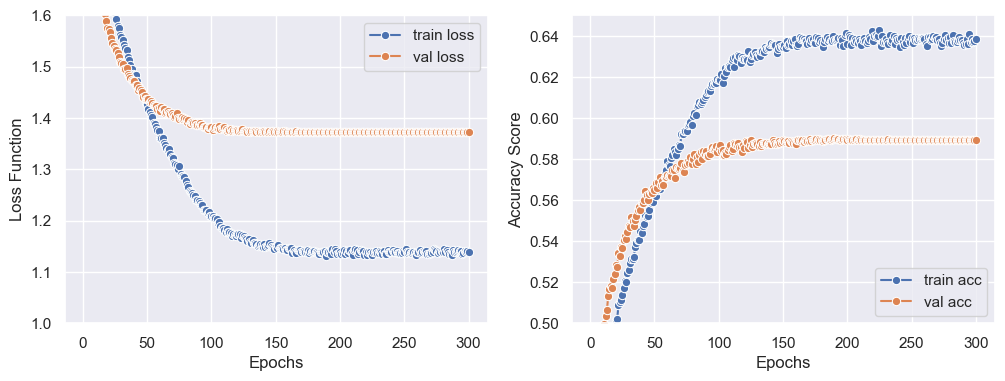

In [151]:
## compare different lr_schedules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

art = sns.color_palette()
x_epochs = np.arange(1,Nb_epochs + 1,1)
# offset = [0] + epochs_set

fig, axs = plt.subplots(1,2,figsize=(12,4))

ax = axs[0]
sns.lineplot(x = x_epochs, y = train_loss, ax=ax, marker = 'o', label='train loss', color = art[0])
sns.lineplot(x = x_epochs, y = val_loss, ax=ax, marker = 'o', label='val loss', color = art[1])
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss Function')
# ax.set_ylim(0.6,0.8)
ax.set_ylim(1.0,1.6)

ax = axs[1]
sns.lineplot(x = x_epochs, y = train_acc, ax=ax, marker = 'o', label='train acc', color = art[0])
sns.lineplot(x = x_epochs, y = val_acc, ax=ax, marker = 'o', label='val acc', color = art[1])
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy Score')
# ax.set_ylim(0.80,0.82)
ax.set_ylim(0.5,0.65)
ax.legend(loc = 'lower right')

**train test accuracy**

In [149]:
loss_train, NN_accuracy_train = head_model.evaluate(output_vector_train, yy_train)
print("Train set accuracy = %0.3f and loss function = %0.2f" %(NN_accuracy_train, loss_train) )

loss_val, NN_accuracy_val = head_model.evaluate(output_vector_val, yy_val)
print("Train set accuracy = %0.3f and loss function = %0.2f" %(NN_accuracy_val, loss_val) )

loss_test, NN_accuracy_test = head_model.evaluate(output_vector_test, yy_test)
print("Test  set accuracy = %0.3f and loss function = %0.2f" %(NN_accuracy_test, loss_test))

1699/1699 [==============================] - 6s 3ms/step - loss: 0.8229 - accuracy: 0.7572
Train set accuracy = 0.757 and loss function = 0.82
425/425 [==============================] - 2s 3ms/step - loss: 1.3727 - accuracy: 0.5893
Train set accuracy = 0.589 and loss function = 1.37
531/531 [==============================] - 7s 12ms/step - loss: 1.3623 - accuracy: 0.5930
Test  set accuracy = 0.593 and loss function = 1.36


**Save or Reload trained text model**

In [4]:
save = False
reload = True

import tensorflow as tf

if save:
    vggt.save_model(head_model, name = 'HeadModel_for_headlessVGG__trained', 
                  path = '../Base_models/Image_VGG/', 
                  doit = True)
    

if reload:
    model_filename = '../Base_models/Image_VGG/2308311654_HeadModel_for_headlessVGG__trained.keras'
    head_model = tf.keras.models.load_model(model_filename)
    head_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                      

In [23]:
model_date_time = '2308311654'  # From onenote

### Make predictions & evaluate

**train test accuracy**

In [8]:
vggt.get_train_test_accuracy(head_model, output_vector_train, output_vector_test, yy_train, yy_test)

531/531 [==============================] - 1s 3ms/step - loss: 1.3623 - accuracy: 0.5930
Train set accuracy = 0.757 and loss function = 0.82
Test  set accuracy = 0.593 and loss function = 1.36


**Confusion Matrix**

In [24]:
t0 = time.time()
y_pred_vectors = head_model.predict(output_vector_test)
t1 = time.time()
print(t1-t0, "seconds")

531/531 [==============================] - 1s 2ms/step
1.5654935836791992 seconds


In [17]:
cm = vggt.get_confusionMatrix(yy_test, y_pred_vectors, 
                       target_encoder, product_class['prdtypecode'])

(27, 27)


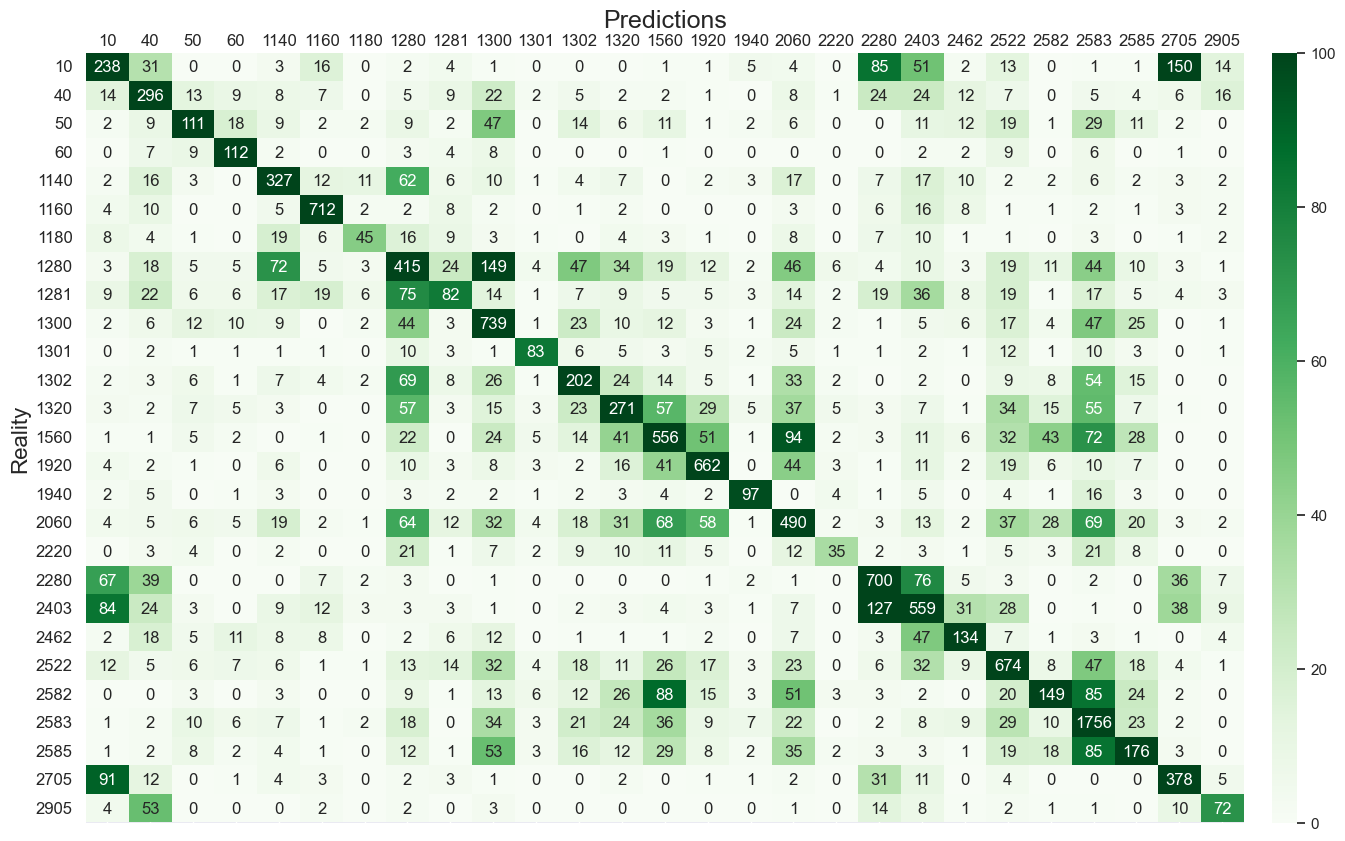

In [41]:
vggt.plot_confusionMatrix(cm)

**Save confusion matrix**

In [26]:
save_metrics = True

if save_metrics:
    vggt.save_model_metrics(cm, metric_type = 'confusionMatrix', model_name = 'HeadModel_for_headlessVGG',
                         path = '../Base_models/Image_VGG/', timestamp = model_date_time)

../Base_models/Image_VGG/2308311654_HeadModel_for_headlessVGG_confusionMatrix.csv


**Classification Report: macro & micro**

In [21]:
cr, micro_cr, macro_cr = vggt.get_classificationReport(yy_test, y_pred_vectors,
                                                     target_encoder, product_class['prdtypecode'])

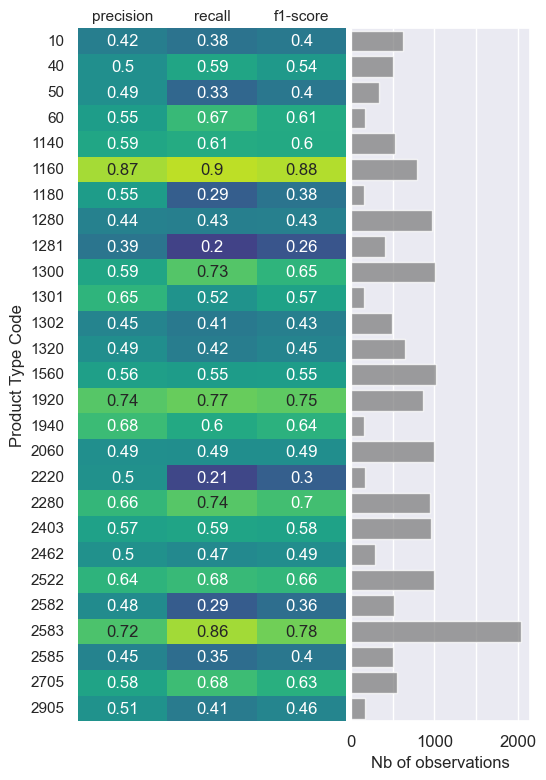

In [43]:
vggt.plot_classificationReport(micro_cr)

**Save classification report**

In [52]:
export = True
path = '../Base_models/Image_VGG/'
if export:
    vggt.save_model_metrics(cr, metric_type = 'classificationReport_txt', 
                                   model_name = 'HeadModel_for_headlessVGG', 
                                   path = path , 
                                   timestamp = model_date_time )

    vggt.save_model_metrics(micro_cr, metric_type = 'classificationReport_df', 
                                   model_name = 'HeadModel_for_headlessVGG_micro', 
                                   path = path , 
                                   timestamp = model_date_time )

    vggt.save_model_metrics(macro_cr, metric_type = 'classificationReport_df', 
                                   model_name = 'HeadModel_for_headlessVGG_macro', 
                                   path = path , 
                                   timestamp = model_date_time )

../Base_models/Image_VGG/2308311654_HeadModel_for_headlessVGG_classificationReport.txt
../Base_models/Image_VGG/2308311654_HeadModel_for_headlessVGG_micro_classificationReport.csv
../Base_models/Image_VGG/2308311654_HeadModel_for_headlessVGG_macro_classificationReport.csv


In [53]:
print(cr)

              precision    recall  f1-score   support

          10       0.42      0.38      0.40       623
          40       0.50      0.59      0.54       502
          50       0.49      0.33      0.40       336
          60       0.55      0.67      0.61       166
        1140       0.59      0.61      0.60       534
        1160       0.87      0.90      0.88       791
        1180       0.55      0.29      0.38       153
        1280       0.44      0.43      0.43       974
        1281       0.39      0.20      0.26       414
        1300       0.59      0.73      0.65      1009
        1301       0.65      0.52      0.57       161
        1302       0.45      0.41      0.43       498
        1320       0.49      0.42      0.45       648
        1560       0.56      0.55      0.55      1015
        1920       0.74      0.77      0.75       861
        1940       0.68      0.60      0.64       161
        2060       0.49      0.49      0.49       999
        2220       0.50    

**Top Classified Categories**

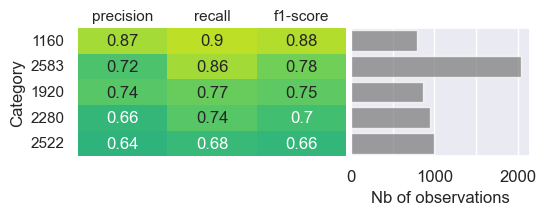

In [64]:
micro_best = micro_cr.sort_values(by = 'f1-score', ascending=False).head(5) 
vggt.plot_classificationReport_extract(micro_best, nb_classes = 27, nb_2show = len(micro_best))

**Worst Classified Categories**

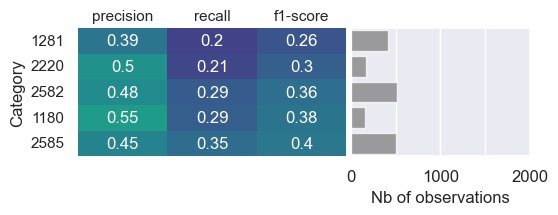

In [60]:
micro_worst = micro_cr.sort_values(by = 'f1-score', ascending=True).head(5)
vggt.plot_classificationReport_extract(micro_worst)

**Less represented categories scores**

In [56]:
micro_cr.sort_values(by = 'support', ascending=True).head(5)

,prdtypecode,precision,recall,f1-score,support
6,1180,0.548780,0.294118,0.382979,153.0
10,1301,0.648438,0.515528,0.574394,161.0
15,1940,0.683099,0.602484,0.640264,161.0
17,2220,0.500000,0.212121,0.297872,165.0
3,60,0.554455,0.674699,0.608696,166.0


### HyperParameter optimization

In [175]:
Nb_epochs = 60  # Nb of epoch for training
lr_0 = 0.5e-3     # intial learning rate

dense1_units = [1024,512,256,128,64]
dense2_units = [512,256,128,64]  # 10 in total
drop_range = [0.4,0.7]           # x2 = 20 in total @ 20 min each (60 epochs) 3/hour --> 7 hs for the 30

param_trained = []
train_histories = []
acc_train = []
acc_test = []
losses_train = []
losses_test = []

for u1 in dense1_units:
    for u2 in dense2_units:
        if u2 <= u1:
            for drop in drop_range:
                
                param_trained.append( (u1, u2, drop, drop) ) 
                print("Model parameters :", u1, u2, drop, drop)
                
                name = 'params_' + str(u1) + '_' + str(u2)
                checkpoint_path = vggt.create_checkpoint_folders(foldername = name, 
                                                            checkpoints_path = './tmp_checkpoint/img_baseModel_vgg_refined/')
                
                head_model = Sequential()
                head_model.add( Flatten(input_shape = output_vector_train.shape[1:]) )
                head_model.add( Dense(units = u1, activation = 'relu') )
                head_model.add( Dropout(rate = drop) )
                head_model.add( Dense(units = u2, activation = 'relu') )
                head_model.add( Dropout(rate = drop) )
                head_model.add( Dense(units = Nb_classes, activation='softmax') )
                
                head_model.summary()
                
                optimizer = Adam(learning_rate = lr_0)
                head_model.compile(loss = 'categorical_crossentropy',  # because targets are one hot encoded
                                  optimizer = optimizer,
                                  metrics = ['accuracy'])
                
                training_history = head_model.fit(output_vector_train, yy_train,
                                               validation_data = (output_vector_val, yy_val),
                                               epochs = Nb_epochs,
                                               batch_size = 400,
                                               callbacks = [
                                                           vggt.get_reduceLRonPlateau(),
                                                           vggt.get_model_checkpoint(checkpoint_path)
                                                           ])

                head_model.load_weights(checkpoint_path)

                train_histories.append(training_history)

                ## train test accuracy
                loss_train, accuracy_train = head_model.evaluate(output_vector_train, yy_train)         
                loss_test, accuracy_test = head_model.evaluate(output_vector_test, yy_test)
         
                losses_train.append(loss_train)
                losses_test.append(loss_test)

                acc_train.append(accuracy_train)
                acc_test.append(accuracy_test)

results = {'param_trained' : param_trained,
           'train_histories' : train_histories,
           'accuracy_train' : acc_train,
           'accuracy_test' : acc_test,
           'loss_train' : losses_train,
           'loss_test' : losses_test}

Model parameters : 1024 512 0.4 0.4
created folder
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_47 (Flatten)        (None, 25088)             0         
                                                                 
 dense_140 (Dense)           (None, 1024)              25691136  
                                                                 
 dropout_84 (Dropout)        (None, 1024)              0         
                                                                 
 dense_141 (Dense)           (None, 512)               524800    
                                                                 
 dropout_85 (Dropout)        (None, 512)               0         
                                                                 
 dense_142 (Dense)           (None, 27)                13851     
                                                                 
To

Epoch 21/60
136/136 [==============================] - ETA: 0s - loss: 0.3395 - accuracy: 0.8883
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00017150000203400848.

Epoch 21: val_accuracy did not improve from 0.59358
136/136 [==============================] - 36s 263ms/step - loss: 0.3395 - accuracy: 0.8883 - val_loss: 1.9385 - val_accuracy: 0.5898 - lr: 2.4500e-04
Epoch 22/60
136/136 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.9036
Epoch 22: val_accuracy did not improve from 0.59358
136/136 [==============================] - 36s 263ms/step - loss: 0.2914 - accuracy: 0.9036 - val_loss: 1.9718 - val_accuracy: 0.5872 - lr: 1.7150e-04
Epoch 23/60
136/136 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.9121
Epoch 23: val_accuracy did not improve from 0.59358
136/136 [==============================] - 36s 263ms/step - loss: 0.2671 - accuracy: 0.9121 - val_loss: 1.9841 - val_accuracy: 0.5912 - lr: 1.7150e-04
Epoch 24/60
136/136 [


Epoch 46: val_accuracy did not improve from 0.59520
136/136 [==============================] - 36s 265ms/step - loss: 0.1133 - accuracy: 0.9635 - val_loss: 2.4770 - val_accuracy: 0.5940 - lr: 4.1177e-05
Epoch 47/60
136/136 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9654
Epoch 47: val_accuracy did not improve from 0.59520
136/136 [==============================] - 36s 265ms/step - loss: 0.1087 - accuracy: 0.9654 - val_loss: 2.4708 - val_accuracy: 0.5923 - lr: 2.8824e-05
Epoch 48/60
136/136 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9633
Epoch 48: val_accuracy did not improve from 0.59520
136/136 [==============================] - 36s 264ms/step - loss: 0.1110 - accuracy: 0.9633 - val_loss: 2.4971 - val_accuracy: 0.5930 - lr: 2.8824e-05
Epoch 49/60
136/136 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9650
Epoch 49: val_accuracy improved from 0.59520 to 0.59535, saving model to ./tmp_checkpoint/img_baseM

136/136 [==============================] - 37s 271ms/step - loss: 1.9817 - accuracy: 0.4069 - val_loss: 1.8202 - val_accuracy: 0.4956 - lr: 5.0000e-04
Epoch 7/60
136/136 [==============================] - ETA: 0s - loss: 1.9517 - accuracy: 0.4121
Epoch 7: val_accuracy did not improve from 0.49562
136/136 [==============================] - 36s 267ms/step - loss: 1.9517 - accuracy: 0.4121 - val_loss: 1.7988 - val_accuracy: 0.4950 - lr: 5.0000e-04
Epoch 8/60
136/136 [==============================] - ETA: 0s - loss: 1.9053 - accuracy: 0.4230
Epoch 8: val_accuracy did not improve from 0.49562
136/136 [==============================] - 36s 267ms/step - loss: 1.9053 - accuracy: 0.4230 - val_loss: 1.7719 - val_accuracy: 0.4947 - lr: 5.0000e-04
Epoch 9/60
136/136 [==============================] - ETA: 0s - loss: 1.8595 - accuracy: 0.4330
Epoch 9: val_accuracy improved from 0.49562 to 0.50990, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_512\
136/136 [================

Epoch 32/60
136/136 [==============================] - ETA: 0s - loss: 1.4762 - accuracy: 0.5175
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.

Epoch 32: val_accuracy did not improve from 0.52690
136/136 [==============================] - 36s 263ms/step - loss: 1.4762 - accuracy: 0.5175 - val_loss: 1.6261 - val_accuracy: 0.5252 - lr: 5.0000e-04
Epoch 33/60
136/136 [==============================] - ETA: 0s - loss: 1.4272 - accuracy: 0.5311
Epoch 33: val_accuracy improved from 0.52690 to 0.52926, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_512\
136/136 [==============================] - 38s 276ms/step - loss: 1.4272 - accuracy: 0.5311 - val_loss: 1.6205 - val_accuracy: 0.5293 - lr: 3.5000e-04
Epoch 34/60
136/136 [==============================] - ETA: 0s - loss: 1.4063 - accuracy: 0.5356
Epoch 34: val_accuracy did not improve from 0.52926
136/136 [==============================] - 36s 268ms/step - loss: 1.4063 - accuracy: 0.5356

Epoch 57/60
136/136 [==============================] - ETA: 0s - loss: 1.1442 - accuracy: 0.6013
Epoch 57: ReduceLROnPlateau reducing learning rate to 5.882449768250808e-05.

Epoch 57: val_accuracy did not improve from 0.53382
136/136 [==============================] - 36s 262ms/step - loss: 1.1442 - accuracy: 0.6013 - val_loss: 1.7318 - val_accuracy: 0.5293 - lr: 8.4035e-05
Epoch 58/60
136/136 [==============================] - ETA: 0s - loss: 1.1344 - accuracy: 0.6023
Epoch 58: val_accuracy did not improve from 0.53382
136/136 [==============================] - 36s 267ms/step - loss: 1.1344 - accuracy: 0.6023 - val_loss: 1.7563 - val_accuracy: 0.5298 - lr: 5.8824e-05
Epoch 59/60
136/136 [==============================] - ETA: 0s - loss: 1.1263 - accuracy: 0.6076
Epoch 59: val_accuracy did not improve from 0.53382
136/136 [==============================] - 36s 262ms/step - loss: 1.1263 - accuracy: 0.6076 - val_loss: 1.7476 - val_accuracy: 0.5284 - lr: 5.8824e-05
Epoch 60/60
136/136 [=

136/136 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.9502
Epoch 41: val_accuracy did not improve from 0.59638
136/136 [==============================] - 35s 260ms/step - loss: 0.1537 - accuracy: 0.9502 - val_loss: 2.2194 - val_accuracy: 0.5962 - lr: 5.8824e-05
Epoch 42/60
136/136 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.9513
Epoch 42: ReduceLROnPlateau reducing learning rate to 4.117714888707269e-05.

Epoch 42: val_accuracy did not improve from 0.59638
136/136 [==============================] - 35s 259ms/step - loss: 0.1515 - accuracy: 0.9513 - val_loss: 2.2494 - val_accuracy: 0.5942 - lr: 5.8824e-05
Epoch 43/60
136/136 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.9530
Epoch 43: val_accuracy did not improve from 0.59638
136/136 [==============================] - 35s 260ms/step - loss: 0.1471 - accuracy: 0.9530 - val_loss: 2.2448 - val_accuracy: 0.5940 - lr: 4.1177e-05
Epoch 44/60
136/136 [=============

Epoch 2/60
136/136 [==============================] - ETA: 0s - loss: 2.4615 - accuracy: 0.2910
Epoch 2: val_accuracy improved from 0.36483 to 0.43336, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_256\
136/136 [==============================] - 37s 269ms/step - loss: 2.4615 - accuracy: 0.2910 - val_loss: 2.1044 - val_accuracy: 0.4334 - lr: 5.0000e-04
Epoch 3/60
136/136 [==============================] - ETA: 0s - loss: 2.2956 - accuracy: 0.3341
Epoch 3: val_accuracy improved from 0.43336 to 0.45772, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_256\
136/136 [==============================] - 37s 272ms/step - loss: 2.2956 - accuracy: 0.3341 - val_loss: 1.9648 - val_accuracy: 0.4577 - lr: 5.0000e-04
Epoch 4/60
136/136 [==============================] - ETA: 0s - loss: 2.2025 - accuracy: 0.3565
Epoch 4: val_accuracy improved from 0.45772 to 0.46353, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_256\
136/136 [=====

Epoch 25/60
136/136 [==============================] - ETA: 0s - loss: 1.6310 - accuracy: 0.4841
Epoch 25: val_accuracy did not improve from 0.52064
136/136 [==============================] - 35s 258ms/step - loss: 1.6310 - accuracy: 0.4841 - val_loss: 1.6419 - val_accuracy: 0.5164 - lr: 5.0000e-04
Epoch 26/60
136/136 [==============================] - ETA: 0s - loss: 1.6208 - accuracy: 0.4866
Epoch 26: val_accuracy did not improve from 0.52064
136/136 [==============================] - 35s 260ms/step - loss: 1.6208 - accuracy: 0.4866 - val_loss: 1.6330 - val_accuracy: 0.5201 - lr: 5.0000e-04
Epoch 27/60
136/136 [==============================] - ETA: 0s - loss: 1.6064 - accuracy: 0.4893
Epoch 27: val_accuracy did not improve from 0.52064
136/136 [==============================] - 35s 260ms/step - loss: 1.6064 - accuracy: 0.4893 - val_loss: 1.6390 - val_accuracy: 0.5195 - lr: 5.0000e-04
Epoch 28/60
136/136 [==============================] - ETA: 0s - loss: 1.5997 - accuracy: 0.4923
Epo

136/136 [==============================] - 35s 260ms/step - loss: 1.2895 - accuracy: 0.5609 - val_loss: 1.7036 - val_accuracy: 0.5379 - lr: 1.7150e-04
Epoch 50/60
136/136 [==============================] - ETA: 0s - loss: 1.2948 - accuracy: 0.5600
Epoch 50: ReduceLROnPlateau reducing learning rate to 0.00012004999734926967.

Epoch 50: val_accuracy improved from 0.53831 to 0.53919, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_256\
136/136 [==============================] - 36s 268ms/step - loss: 1.2948 - accuracy: 0.5600 - val_loss: 1.7151 - val_accuracy: 0.5392 - lr: 1.7150e-04
Epoch 51/60
136/136 [==============================] - ETA: 0s - loss: 1.2802 - accuracy: 0.5631
Epoch 51: val_accuracy did not improve from 0.53919
136/136 [==============================] - 35s 259ms/step - loss: 1.2802 - accuracy: 0.5631 - val_loss: 1.7217 - val_accuracy: 0.5388 - lr: 1.2005e-04
Epoch 52/60
136/136 [==============================] - ETA: 0s - loss: 1.2648 - accuracy:

Epoch 9/60
136/136 [==============================] - ETA: 0s - loss: 1.1361 - accuracy: 0.6525
Epoch 9: val_accuracy improved from 0.57400 to 0.58033, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_128\
136/136 [==============================] - 36s 265ms/step - loss: 1.1361 - accuracy: 0.6525 - val_loss: 1.4443 - val_accuracy: 0.5803 - lr: 5.0000e-04
Epoch 10/60
136/136 [==============================] - ETA: 0s - loss: 1.0562 - accuracy: 0.6755
Epoch 10: val_accuracy improved from 0.58033 to 0.58401, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_128\
136/136 [==============================] - 36s 267ms/step - loss: 1.0562 - accuracy: 0.6755 - val_loss: 1.4376 - val_accuracy: 0.5840 - lr: 5.0000e-04
Epoch 11/60
136/136 [==============================] - ETA: 0s - loss: 0.9998 - accuracy: 0.6923
Epoch 11: val_accuracy did not improve from 0.58401
136/136 [==============================] - 35s 258ms/step - loss: 0.9998 - accuracy: 0.6923

Epoch 33/60
136/136 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9226
Epoch 33: ReduceLROnPlateau reducing learning rate to 8.403499814448878e-05.

Epoch 33: val_accuracy did not improve from 0.59594
136/136 [==============================] - 35s 255ms/step - loss: 0.2433 - accuracy: 0.9226 - val_loss: 1.9894 - val_accuracy: 0.5925 - lr: 1.2005e-04
Epoch 34/60
136/136 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9244
Epoch 34: val_accuracy did not improve from 0.59594
136/136 [==============================] - 35s 256ms/step - loss: 0.2326 - accuracy: 0.9244 - val_loss: 1.9855 - val_accuracy: 0.5947 - lr: 8.4035e-05
Epoch 35/60
136/136 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.9274
Epoch 35: val_accuracy did not improve from 0.59594
136/136 [==============================] - 35s 257ms/step - loss: 0.2266 - accuracy: 0.9274 - val_loss: 2.0225 - val_accuracy: 0.5943 - lr: 8.4035e-05
Epoch 36/60
136/136 [=


Epoch 58: val_accuracy did not improve from 0.59719
136/136 [==============================] - 35s 256ms/step - loss: 0.1553 - accuracy: 0.9515 - val_loss: 2.2119 - val_accuracy: 0.5947 - lr: 2.0177e-05
Epoch 59/60
136/136 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9518
Epoch 59: val_accuracy did not improve from 0.59719
136/136 [==============================] - 35s 256ms/step - loss: 0.1526 - accuracy: 0.9518 - val_loss: 2.2194 - val_accuracy: 0.5951 - lr: 1.4124e-05
Epoch 60/60
136/136 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.9514
Epoch 60: val_accuracy did not improve from 0.59719
531/531 [==============================] - 8s 15ms/step - loss: 2.1296 - accuracy: 0.6003
Model parameters : 1024 128 0.7 0.7
 exists!
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_52 (Flatten)        (None, 25088)             0 

Epoch 18/60
136/136 [==============================] - ETA: 0s - loss: 1.7868 - accuracy: 0.4557
Epoch 18: val_accuracy improved from 0.50681 to 0.50747, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_128\
136/136 [==============================] - 37s 269ms/step - loss: 1.7868 - accuracy: 0.4557 - val_loss: 1.6670 - val_accuracy: 0.5075 - lr: 5.0000e-04
Epoch 19/60
136/136 [==============================] - ETA: 0s - loss: 1.7725 - accuracy: 0.4578
Epoch 19: val_accuracy did not improve from 0.50747
136/136 [==============================] - 35s 260ms/step - loss: 1.7725 - accuracy: 0.4578 - val_loss: 1.6656 - val_accuracy: 0.5022 - lr: 5.0000e-04
Epoch 20/60
136/136 [==============================] - ETA: 0s - loss: 1.7573 - accuracy: 0.4610
Epoch 20: val_accuracy did not improve from 0.50747
136/136 [==============================] - 35s 259ms/step - loss: 1.7573 - accuracy: 0.4610 - val_loss: 1.6598 - val_accuracy: 0.5068 - lr: 5.0000e-04
Epoch 21/60
136/136

136/136 [==============================] - ETA: 0s - loss: 1.4108 - accuracy: 0.5419
Epoch 41: val_accuracy did not improve from 0.53941
136/136 [==============================] - 35s 260ms/step - loss: 1.4108 - accuracy: 0.5419 - val_loss: 1.6667 - val_accuracy: 0.5344 - lr: 2.4500e-04
Epoch 42/60
136/136 [==============================] - ETA: 0s - loss: 1.4118 - accuracy: 0.5401
Epoch 42: ReduceLROnPlateau reducing learning rate to 0.00017150000203400848.

Epoch 42: val_accuracy improved from 0.53941 to 0.53971, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_128\
136/136 [==============================] - 36s 268ms/step - loss: 1.4118 - accuracy: 0.5401 - val_loss: 1.6710 - val_accuracy: 0.5397 - lr: 2.4500e-04
Epoch 43/60
136/136 [==============================] - ETA: 0s - loss: 1.3835 - accuracy: 0.5463
Epoch 43: val_accuracy did not improve from 0.53971
136/136 [==============================] - 35s 258ms/step - loss: 1.3835 - accuracy: 0.5463 - val_loss:

Epoch 1/60
136/136 [==============================] - ETA: 0s - loss: 2.8071 - accuracy: 0.2185
Epoch 1: val_accuracy improved from -inf to 0.43291, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_64\
136/136 [==============================] - 39s 279ms/step - loss: 2.8071 - accuracy: 0.2185 - val_loss: 2.0924 - val_accuracy: 0.4329 - lr: 5.0000e-04
Epoch 2/60
136/136 [==============================] - ETA: 0s - loss: 2.1286 - accuracy: 0.3967
Epoch 2: val_accuracy improved from 0.43291 to 0.48716, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_64\
136/136 [==============================] - 36s 265ms/step - loss: 2.1286 - accuracy: 0.3967 - val_loss: 1.7658 - val_accuracy: 0.4872 - lr: 5.0000e-04
Epoch 3/60
136/136 [==============================] - ETA: 0s - loss: 1.8836 - accuracy: 0.4568
Epoch 3: val_accuracy improved from 0.48716 to 0.51512, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_64\
136/136 [===========

Epoch 24/60
136/136 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.8456
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00017150000203400848.

Epoch 24: val_accuracy did not improve from 0.59689
136/136 [==============================] - 35s 256ms/step - loss: 0.4828 - accuracy: 0.8456 - val_loss: 1.7329 - val_accuracy: 0.5931 - lr: 2.4500e-04
Epoch 25/60
136/136 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8614
Epoch 25: val_accuracy improved from 0.59689 to 0.59704, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_64\
136/136 [==============================] - 37s 274ms/step - loss: 0.4412 - accuracy: 0.8614 - val_loss: 1.7733 - val_accuracy: 0.5970 - lr: 1.7150e-04
Epoch 26/60
136/136 [==============================] - ETA: 0s - loss: 0.4223 - accuracy: 0.8673
Epoch 26: val_accuracy did not improve from 0.59704
136/136 [==============================] - 35s 256ms/step - loss: 0.4223 - accuracy: 0.8673 

136/136 [==============================] - 35s 256ms/step - loss: 0.2358 - accuracy: 0.9270 - val_loss: 2.0845 - val_accuracy: 0.5965 - lr: 4.1177e-05
Epoch 50/60
136/136 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.9265
Epoch 50: val_accuracy did not improve from 0.59704
136/136 [==============================] - 35s 256ms/step - loss: 0.2317 - accuracy: 0.9265 - val_loss: 2.0832 - val_accuracy: 0.5967 - lr: 2.8824e-05
Epoch 51/60
136/136 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.9291
Epoch 51: val_accuracy did not improve from 0.59704
136/136 [==============================] - 35s 257ms/step - loss: 0.2276 - accuracy: 0.9291 - val_loss: 2.1064 - val_accuracy: 0.5966 - lr: 2.8824e-05
Epoch 52/60
136/136 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9290
Epoch 52: val_accuracy did not improve from 0.59704
136/136 [==============================] - 35s 257ms/step - loss: 0.2268 - accuracy: 0.9290 - val_lo

136/136 [==============================] - ETA: 0s - loss: 1.6168 - accuracy: 0.4933
Epoch 33: val_accuracy did not improve from 0.51807
136/136 [==============================] - 35s 255ms/step - loss: 1.6168 - accuracy: 0.4933 - val_loss: 1.6550 - val_accuracy: 0.5177 - lr: 3.5000e-04
Epoch 34/60
136/136 [==============================] - ETA: 0s - loss: 1.6128 - accuracy: 0.4931
Epoch 34: val_accuracy improved from 0.51807 to 0.51998, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_64\
136/136 [==============================] - 36s 268ms/step - loss: 1.6128 - accuracy: 0.4931 - val_loss: 1.6638 - val_accuracy: 0.5200 - lr: 3.5000e-04
Epoch 35/60
136/136 [==============================] - ETA: 0s - loss: 1.6102 - accuracy: 0.4973
Epoch 35: val_accuracy did not improve from 0.51998
136/136 [==============================] - 35s 255ms/step - loss: 1.6102 - accuracy: 0.4973 - val_loss: 1.6631 - val_accuracy: 0.5188 - lr: 3.5000e-04
Epoch 36/60
136/136 [===========

136/136 [==============================] - 35s 258ms/step - loss: 1.4027 - accuracy: 0.5369 - val_loss: 1.7446 - val_accuracy: 0.5272 - lr: 8.4035e-05
Epoch 57/60
136/136 [==============================] - ETA: 0s - loss: 1.3987 - accuracy: 0.5362
Epoch 57: val_accuracy did not improve from 0.53117
136/136 [==============================] - 35s 259ms/step - loss: 1.3987 - accuracy: 0.5362 - val_loss: 1.7567 - val_accuracy: 0.5289 - lr: 5.8824e-05
Epoch 58/60
136/136 [==============================] - ETA: 0s - loss: 1.3940 - accuracy: 0.5384
Epoch 58: val_accuracy did not improve from 0.53117
136/136 [==============================] - 35s 257ms/step - loss: 1.3940 - accuracy: 0.5384 - val_loss: 1.7533 - val_accuracy: 0.5303 - lr: 5.8824e-05
Epoch 59/60
136/136 [==============================] - ETA: 0s - loss: 1.3880 - accuracy: 0.5373
Epoch 59: val_accuracy improved from 0.53117 to 0.53183, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_1024_64\
136/136 [===========

Epoch 16/60
136/136 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.8005
Epoch 16: val_accuracy did not improve from 0.58504
136/136 [==============================] - 20s 144ms/step - loss: 0.6043 - accuracy: 0.8005 - val_loss: 1.6666 - val_accuracy: 0.5768 - lr: 3.5000e-04
Epoch 17/60
136/136 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.8608
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00017150000203400848.

Epoch 22: val_accuracy improved from 0.58504 to 0.58519, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_512\
136/136 [==============================] - 21s 152ms/step - loss: 0.4093 - accuracy: 0.8608 - val_loss: 1.8658 - val_accuracy: 0.5852 - lr: 2.4500e-04
Epoch 23/60
136/136 [==============================] - ETA: 0s - loss: 0.3652 - accuracy: 0.8774
Epoch 23: val_accuracy improved from 0.58519 to 0.58681, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_512\
136/136 [===

136/136 [==============================] - 19s 141ms/step - loss: 0.1869 - accuracy: 0.9372 - val_loss: 2.4013 - val_accuracy: 0.5867 - lr: 4.1177e-05
Epoch 46/60
136/136 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9378
Epoch 46: val_accuracy did not improve from 0.58909
136/136 [==============================] - 19s 141ms/step - loss: 0.1832 - accuracy: 0.9378 - val_loss: 2.3904 - val_accuracy: 0.5867 - lr: 4.1177e-05
Epoch 47/60
136/136 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9375
Epoch 47: ReduceLROnPlateau reducing learning rate to 2.88240029476583e-05.

Epoch 47: val_accuracy did not improve from 0.58909
136/136 [==============================] - 19s 141ms/step - loss: 0.1847 - accuracy: 0.9375 - val_loss: 2.4145 - val_accuracy: 0.5865 - lr: 4.1177e-05
Epoch 48/60
136/136 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9403
Epoch 48: val_accuracy did not improve from 0.58909
136/136 [==============

Epoch 6/60
136/136 [==============================] - ETA: 0s - loss: 2.1805 - accuracy: 0.3458
Epoch 6: val_accuracy did not improve from 0.46360
136/136 [==============================] - 19s 137ms/step - loss: 2.1805 - accuracy: 0.3458 - val_loss: 1.9733 - val_accuracy: 0.4613 - lr: 5.0000e-04
Epoch 7/60
136/136 [==============================] - ETA: 0s - loss: 2.1484 - accuracy: 0.3526
Epoch 7: val_accuracy did not improve from 0.46360
136/136 [==============================] - 19s 137ms/step - loss: 2.1484 - accuracy: 0.3526 - val_loss: 1.9594 - val_accuracy: 0.4495 - lr: 5.0000e-04
Epoch 8/60
136/136 [==============================] - ETA: 0s - loss: 2.1114 - accuracy: 0.3616
Epoch 8: val_accuracy improved from 0.46360 to 0.46839, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_512\
136/136 [==============================] - 20s 147ms/step - loss: 2.1114 - accuracy: 0.3616 - val_loss: 1.9338 - val_accuracy: 0.4684 - lr: 5.0000e-04
Epoch 9/60
136/136 [======

Epoch 58/60
136/136 [==============================] - ETA: 0s - loss: 1.4957 - accuracy: 0.5092
Epoch 58: val_accuracy did not improve from 0.47994
136/136 [==============================] - 19s 137ms/step - loss: 1.4957 - accuracy: 0.5092 - val_loss: 1.8671 - val_accuracy: 0.4473 - lr: 1.2005e-04
Epoch 59/60
136/136 [==============================] - ETA: 0s - loss: 1.4878 - accuracy: 0.5133
Epoch 59: val_accuracy did not improve from 0.47994
136/136 [==============================] - 19s 138ms/step - loss: 1.4878 - accuracy: 0.5133 - val_loss: 1.8713 - val_accuracy: 0.4462 - lr: 1.2005e-04
Epoch 60/60
136/136 [==============================] - ETA: 0s - loss: 1.4814 - accuracy: 0.5111
Epoch 60: ReduceLROnPlateau reducing learning rate to 8.403499814448878e-05.

Epoch 60: val_accuracy did not improve from 0.47994
531/531 [==============================] - 5s 9ms/step - loss: 1.8421 - accuracy: 0.4814
Model parameters : 512 256 0.4 0.4
 exists!
Model: "sequential_58"
_________________

136/136 [==============================] - 20s 144ms/step - loss: 2.6923 - accuracy: 0.2142 - val_loss: 2.4010 - val_accuracy: 0.3606 - lr: 5.0000e-04
Epoch 3/60
136/136 [==============================] - ETA: 0s - loss: 2.5840 - accuracy: 0.2356
Epoch 3: val_accuracy improved from 0.36064 to 0.38368, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_256\
136/136 [==============================] - 20s 149ms/step - loss: 2.5840 - accuracy: 0.2356 - val_loss: 2.2622 - val_accuracy: 0.3837 - lr: 5.0000e-04
Epoch 4/60
136/136 [==============================] - ETA: 0s - loss: 2.4923 - accuracy: 0.2566
Epoch 4: val_accuracy improved from 0.38368 to 0.39641, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_256\
136/136 [==============================] - 19s 141ms/step - loss: 2.4923 - accuracy: 0.2566 - val_loss: 2.2316 - val_accuracy: 0.3964 - lr: 5.0000e-04
Epoch 5/60
136/136 [==============================] - ETA: 0s - loss: 2.4415 - accuracy: 0.26

Epoch 51/60
136/136 [==============================] - ETA: 0s - loss: 1.8956 - accuracy: 0.3923
Epoch 51: val_accuracy did not improve from 0.42143
136/136 [==============================] - 19s 136ms/step - loss: 1.8956 - accuracy: 0.3923 - val_loss: 1.9955 - val_accuracy: 0.3921 - lr: 1.2005e-04
Epoch 52/60
136/136 [==============================] - ETA: 0s - loss: 1.8943 - accuracy: 0.3937
Epoch 52: ReduceLROnPlateau reducing learning rate to 8.403499814448878e-05.

Epoch 52: val_accuracy did not improve from 0.42143
136/136 [==============================] - 18s 136ms/step - loss: 1.8943 - accuracy: 0.3937 - val_loss: 1.9941 - val_accuracy: 0.3909 - lr: 1.2005e-04
Epoch 53/60
136/136 [==============================] - ETA: 0s - loss: 1.8742 - accuracy: 0.3957
Epoch 57: ReduceLROnPlateau reducing learning rate to 5.882449768250808e-05.

Epoch 57: val_accuracy did not improve from 0.42143
136/136 [==============================] - 18s 136ms/step - loss: 1.8742 - accuracy: 0.3957 - v


Epoch 14: val_accuracy improved from 0.57599 to 0.57724, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_128\
136/136 [==============================] - 19s 138ms/step - loss: 0.9338 - accuracy: 0.7049 - val_loss: 1.5122 - val_accuracy: 0.5772 - lr: 5.0000e-04
Epoch 15/60
136/136 [==============================] - ETA: 0s - loss: 0.8445 - accuracy: 0.7335
Epoch 15: val_accuracy did not improve from 0.57724
136/136 [==============================] - 18s 135ms/step - loss: 0.8445 - accuracy: 0.7335 - val_loss: 1.5328 - val_accuracy: 0.5767 - lr: 3.5000e-04
Epoch 16/60
136/136 [==============================] - ETA: 0s - loss: 0.7939 - accuracy: 0.7478
Epoch 16: val_accuracy did not improve from 0.57724
136/136 [==============================] - 18s 134ms/step - loss: 0.7939 - accuracy: 0.7478 - val_loss: 1.5878 - val_accuracy: 0.5751 - lr: 3.5000e-04
Epoch 17/60
136/136 [==============================] - ETA: 0s - loss: 0.7493 - accuracy: 0.7592
Epoch 17: val_accur

Epoch 39/60
136/136 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8921
Epoch 39: ReduceLROnPlateau reducing learning rate to 5.882449768250808e-05.

Epoch 39: val_accuracy did not improve from 0.58674
136/136 [==============================] - 18s 135ms/step - loss: 0.3214 - accuracy: 0.8921 - val_loss: 2.0262 - val_accuracy: 0.5850 - lr: 8.4035e-05
Epoch 40/60
136/136 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8993
Epoch 40: val_accuracy did not improve from 0.58674
136/136 [==============================] - 18s 134ms/step - loss: 0.3090 - accuracy: 0.8993 - val_loss: 2.0575 - val_accuracy: 0.5860 - lr: 5.8824e-05
Epoch 41/60
136/136 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.9012
Epoch 41: val_accuracy did not improve from 0.58674
136/136 [==============================] - 18s 135ms/step - loss: 0.3023 - accuracy: 0.9012 - val_loss: 2.0568 - val_accuracy: 0.5856 - lr: 5.8824e-05
Epoch 42/60
136/136 [=

Epoch 37/60
136/136 [==============================] - ETA: 0s - loss: 2.1317 - accuracy: 0.3202
Epoch 37: val_accuracy did not improve from 0.40921
136/136 [==============================] - 18s 133ms/step - loss: 2.1317 - accuracy: 0.3202 - val_loss: 1.9881 - val_accuracy: 0.3934 - lr: 3.5000e-04
Epoch 38/60
136/136 [==============================] - ETA: 0s - loss: 2.1130 - accuracy: 0.3276
Epoch 38: val_accuracy did not improve from 0.40921
136/136 [==============================] - 18s 133ms/step - loss: 2.1130 - accuracy: 0.3276 - val_loss: 1.9852 - val_accuracy: 0.4024 - lr: 3.5000e-04
Epoch 39/60
136/136 [==============================] - ETA: 0s - loss: 2.1176 - accuracy: 0.3244
Epoch 39: val_accuracy improved from 0.40921 to 0.41231, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_128\
136/136 [==============================] - 19s 139ms/step - loss: 2.1176 - accuracy: 0.3244 - val_loss: 1.9626 - val_accuracy: 0.4123 - lr: 3.5000e-04
Epoch 40/60
136/136 

Epoch 10/60
136/136 [==============================] - ETA: 0s - loss: 1.2738 - accuracy: 0.6160
Epoch 10: val_accuracy improved from 0.56245 to 0.56333, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_64\
136/136 [==============================] - 19s 140ms/step - loss: 1.2738 - accuracy: 0.6160 - val_loss: 1.4810 - val_accuracy: 0.5633 - lr: 5.0000e-04
Epoch 11/60
136/136 [==============================] - ETA: 0s - loss: 1.2140 - accuracy: 0.6326
Epoch 11: val_accuracy improved from 0.56333 to 0.56451, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_64\
136/136 [==============================] - 19s 140ms/step - loss: 1.2140 - accuracy: 0.6326 - val_loss: 1.4825 - val_accuracy: 0.5645 - lr: 5.0000e-04
Epoch 12/60
136/136 [==============================] - ETA: 0s - loss: 1.1609 - accuracy: 0.6454
Epoch 12: val_accuracy improved from 0.56451 to 0.57032, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_64\
136/136 [=====

136/136 [==============================] - 19s 139ms/step - loss: 0.4631 - accuracy: 0.8499 - val_loss: 1.8565 - val_accuracy: 0.5884 - lr: 1.2005e-04
Epoch 34/60
136/136 [==============================] - ETA: 0s - loss: 0.3789 - accuracy: 0.8756
Epoch 43: val_accuracy did not improve from 0.59086
136/136 [==============================] - 18s 133ms/step - loss: 0.3789 - accuracy: 0.8756 - val_loss: 1.9771 - val_accuracy: 0.5882 - lr: 5.8824e-05
Epoch 44/60
136/136 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8754
Epoch 44: val_accuracy did not improve from 0.59086
136/136 [==============================] - 18s 134ms/step - loss: 0.3812 - accuracy: 0.8754 - val_loss: 1.9825 - val_accuracy: 0.5883 - lr: 5.8824e-05
Epoch 45/60
136/136 [==============================] - ETA: 0s - loss: 0.3765 - accuracy: 0.8777
Epoch 45: val_accuracy did not improve from 0.59086
136/136 [==============================] - 18s 133ms/step - loss: 0.3765 - accuracy: 0.8777 - val_lo

136/136 [==============================] - 19s 141ms/step - loss: 2.7338 - accuracy: 0.2207 - val_loss: 2.4019 - val_accuracy: 0.3313 - lr: 5.0000e-04
Epoch 4/60
136/136 [==============================] - ETA: 0s - loss: 2.6421 - accuracy: 0.2383
Epoch 4: val_accuracy improved from 0.33135 to 0.34128, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_64\
136/136 [==============================] - 19s 141ms/step - loss: 2.6421 - accuracy: 0.2383 - val_loss: 2.2892 - val_accuracy: 0.3413 - lr: 5.0000e-04
Epoch 5/60
136/136 [==============================] - ETA: 0s - loss: 2.5687 - accuracy: 0.2476
Epoch 5: val_accuracy improved from 0.34128 to 0.36388, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_512_64\
136/136 [==============================] - 20s 145ms/step - loss: 2.5687 - accuracy: 0.2476 - val_loss: 2.2145 - val_accuracy: 0.3639 - lr: 5.0000e-04
Epoch 6/60
136/136 [==============================] - ETA: 0s - loss: 2.5154 - accuracy: 0.2604

136/136 [==============================] - ETA: 0s - loss: 2.0067 - accuracy: 0.3572
Epoch 52: val_accuracy did not improve from 0.46360
136/136 [==============================] - 18s 135ms/step - loss: 2.0067 - accuracy: 0.3572 - val_loss: 1.9315 - val_accuracy: 0.4610 - lr: 2.4500e-04
Epoch 53/60
136/136 [==============================] - ETA: 0s - loss: 2.0033 - accuracy: 0.3580
Epoch 53: val_accuracy did not improve from 0.46360
136/136 [==============================] - 18s 133ms/step - loss: 2.0033 - accuracy: 0.3580 - val_loss: 1.9469 - val_accuracy: 0.4623 - lr: 2.4500e-04
Epoch 54/60
136/136 [==============================] - ETA: 0s - loss: 2.0038 - accuracy: 0.3581
Epoch 54: val_accuracy did not improve from 0.46360
136/136 [==============================] - 18s 134ms/step - loss: 2.0038 - accuracy: 0.3581 - val_loss: 1.9510 - val_accuracy: 0.4601 - lr: 2.4500e-04
Epoch 55/60
136/136 [==============================] - ETA: 0s - loss: 1.9988 - accuracy: 0.3586
Epoch 55: Reduc

136/136 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8630
Epoch 36: val_accuracy did not improve from 0.57849
136/136 [==============================] - 11s 80ms/step - loss: 0.4063 - accuracy: 0.8630 - val_loss: 2.0003 - val_accuracy: 0.5746 - lr: 8.4035e-05
Epoch 37/60
136/136 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.8622
Epoch 37: ReduceLROnPlateau reducing learning rate to 5.882449768250808e-05.

Epoch 37: val_accuracy did not improve from 0.57849
136/136 [==============================] - 11s 80ms/step - loss: 0.4036 - accuracy: 0.8622 - val_loss: 1.9862 - val_accuracy: 0.5747 - lr: 8.4035e-05
Epoch 38/60
136/136 [==============================] - ETA: 0s - loss: 0.3887 - accuracy: 0.8679
Epoch 38: val_accuracy did not improve from 0.57849
136/136 [==============================] - 11s 81ms/step - loss: 0.3887 - accuracy: 0.8679 - val_loss: 1.9962 - val_accuracy: 0.5778 - lr: 5.8824e-05
Epoch 39/60
136/136 [================

 flatten_64 (Flatten)        (None, 25088)             0         
                                                                 
 dense_191 (Dense)           (None, 256)               6422784   
                                                                 
 dropout_118 (Dropout)       (None, 256)               0         
                                                                 
 dense_192 (Dense)           (None, 256)               65792     
                                                                 
 dropout_119 (Dropout)       (None, 256)               0         
                                                                 
 dense_193 (Dense)           (None, 27)                6939      
                                                                 
Total params: 6,495,515
Trainable params: 6,495,515
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
136/136 [==============================] - ETA: 0s - lo

136/136 [==============================] - ETA: 0s - loss: 2.6060 - accuracy: 0.2051
Epoch 48: val_accuracy did not improve from 0.28402
136/136 [==============================] - 11s 81ms/step - loss: 2.6060 - accuracy: 0.2051 - val_loss: 2.6308 - val_accuracy: 0.1747 - lr: 4.1177e-05
Epoch 49/60
136/136 [==============================] - ETA: 0s - loss: 2.6083 - accuracy: 0.2063
Epoch 49: val_accuracy did not improve from 0.28402
136/136 [==============================] - 11s 80ms/step - loss: 2.6083 - accuracy: 0.2063 - val_loss: 2.6299 - val_accuracy: 0.1728 - lr: 4.1177e-05
Epoch 50/60
136/136 [==============================] - ETA: 0s - loss: 2.6077 - accuracy: 0.2049
Epoch 50: ReduceLROnPlateau reducing learning rate to 2.88240029476583e-05.

Epoch 50: val_accuracy did not improve from 0.28402
136/136 [==============================] - 11s 80ms/step - loss: 2.6077 - accuracy: 0.2049 - val_loss: 2.6236 - val_accuracy: 0.1757 - lr: 4.1177e-05
Epoch 51/60
136/136 [=================

136/136 [==============================] - 11s 79ms/step - loss: 0.5501 - accuracy: 0.8143 - val_loss: 1.8060 - val_accuracy: 0.5753 - lr: 1.2005e-04
Epoch 32/60
136/136 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.8204
Epoch 32: val_accuracy did not improve from 0.57732
136/136 [==============================] - 11s 79ms/step - loss: 0.5399 - accuracy: 0.8204 - val_loss: 1.8441 - val_accuracy: 0.5739 - lr: 1.2005e-04
Epoch 33/60
136/136 [==============================] - ETA: 0s - loss: 0.5355 - accuracy: 0.8203
Epoch 33: val_accuracy did not improve from 0.57732
136/136 [==============================] - 11s 80ms/step - loss: 0.5355 - accuracy: 0.8203 - val_loss: 1.8618 - val_accuracy: 0.5749 - lr: 1.2005e-04
Epoch 34/60
136/136 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.8201
Epoch 34: ReduceLROnPlateau reducing learning rate to 8.403499814448878e-05.

Epoch 34: val_accuracy did not improve from 0.57732
136/136 [================

Epoch 58/60
136/136 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8604
Epoch 58: val_accuracy did not improve from 0.57732
136/136 [==============================] - 11s 81ms/step - loss: 0.4134 - accuracy: 0.8604 - val_loss: 2.0694 - val_accuracy: 0.5735 - lr: 2.0177e-05
Epoch 59/60
136/136 [==============================] - ETA: 0s - loss: 0.4128 - accuracy: 0.8583
Epoch 59: ReduceLROnPlateau reducing learning rate to 1.4123761138762347e-05.

Epoch 59: val_accuracy did not improve from 0.57732
136/136 [==============================] - 11s 80ms/step - loss: 0.4128 - accuracy: 0.8583 - val_loss: 2.0557 - val_accuracy: 0.5734 - lr: 2.0177e-05
Epoch 60/60
136/136 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8598
Epoch 60: val_accuracy did not improve from 0.57732
531/531 [==============================] - 3s 6ms/step - loss: 1.8003 - accuracy: 0.5804
Model parameters : 256 128 0.7 0.7
 exists!
Model: "sequential_67"
__________________

Epoch 18/60
136/136 [==============================] - ETA: 0s - loss: 2.4582 - accuracy: 0.2490
Epoch 18: val_accuracy did not improve from 0.37050
136/136 [==============================] - 11s 80ms/step - loss: 2.4582 - accuracy: 0.2490 - val_loss: 2.3086 - val_accuracy: 0.3525 - lr: 5.0000e-04
Epoch 19/60
136/136 [==============================] - ETA: 0s - loss: 2.4564 - accuracy: 0.2476
Epoch 19: val_accuracy did not improve from 0.37050
136/136 [==============================] - 11s 82ms/step - loss: 2.4564 - accuracy: 0.2476 - val_loss: 2.2937 - val_accuracy: 0.3520 - lr: 5.0000e-04
Epoch 20/60
136/136 [==============================] - ETA: 0s - loss: 2.4508 - accuracy: 0.2515
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.

Epoch 20: val_accuracy did not improve from 0.37050
136/136 [==============================] - 12s 89ms/step - loss: 2.4508 - accuracy: 0.2515 - val_loss: 2.2904 - val_accuracy: 0.3538 - lr: 5.0000e-04
Epoch 21/60
136/136 [===

Epoch 45/60
136/136 [==============================] - ETA: 0s - loss: 2.2706 - accuracy: 0.2901
Epoch 54: val_accuracy did not improve from 0.37050
136/136 [==============================] - 10s 77ms/step - loss: 2.2706 - accuracy: 0.2901 - val_loss: 2.2393 - val_accuracy: 0.3537 - lr: 1.2005e-04
Epoch 55/60
136/136 [==============================] - ETA: 0s - loss: 2.2666 - accuracy: 0.2890
Epoch 55: ReduceLROnPlateau reducing learning rate to 8.403499814448878e-05.

Epoch 55: val_accuracy did not improve from 0.37050
136/136 [==============================] - 11s 78ms/step - loss: 2.2666 - accuracy: 0.2890 - val_loss: 2.2419 - val_accuracy: 0.3568 - lr: 1.2005e-04
Epoch 56/60
136/136 [==============================] - ETA: 0s - loss: 2.2717 - accuracy: 0.2886
Epoch 56: val_accuracy did not improve from 0.37050
136/136 [==============================] - 10s 77ms/step - loss: 2.2717 - accuracy: 0.2886 - val_loss: 2.2469 - val_accuracy: 0.3523 - lr: 8.4035e-05
Epoch 57/60
136/136 [====

Epoch 60/60
135/136 [============================>.] - ETA: 0s - loss: 0.6044 - accuracy: 0.7974
Epoch 60: ReduceLROnPlateau reducing learning rate to 1.4123761138762347e-05.

Epoch 60: val_accuracy did not improve from 0.57077
531/531 [==============================] - 3s 6ms/step - loss: 1.7649 - accuracy: 0.5741
Model parameters : 256 64 0.7 0.7
 exists!
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_68 (Flatten)        (None, 25088)             0         
                                                                 
 dense_203 (Dense)           (None, 256)               6422784   
                                                                 
 dropout_126 (Dropout)       (None, 256)               0         
                                                                 
 dense_204 (Dense)           (None, 64)                16448     
                       

136/136 [==============================] - 11s 81ms/step - loss: 2.4458 - accuracy: 0.2358 - val_loss: 2.2432 - val_accuracy: 0.3464 - lr: 1.7150e-04
Epoch 50/60
136/136 [==============================] - ETA: 0s - loss: 2.4493 - accuracy: 0.2356
Epoch 50: val_accuracy did not improve from 0.34636
136/136 [==============================] - 10s 76ms/step - loss: 2.4493 - accuracy: 0.2356 - val_loss: 2.2530 - val_accuracy: 0.3423 - lr: 1.7150e-04
Epoch 51/60
136/136 [==============================] - ETA: 0s - loss: 2.4414 - accuracy: 0.2360
Epoch 51: val_accuracy did not improve from 0.34636
136/136 [==============================] - 10s 76ms/step - loss: 2.4414 - accuracy: 0.2360 - val_loss: 2.2537 - val_accuracy: 0.3416 - lr: 1.7150e-04
Epoch 52/60
135/136 [============================>.] - ETA: 0s - loss: 0.7013 - accuracy: 0.7617
Epoch 42: ReduceLROnPlateau reducing learning rate to 5.882449768250808e-05.

Epoch 42: val_accuracy did not improve from 0.56407
136/136 [================

Epoch 26/60
136/136 [==============================] - ETA: 0s - loss: 2.8144 - accuracy: 0.1525
Epoch 26: val_accuracy did not improve from 0.25024
136/136 [==============================] - 6s 47ms/step - loss: 2.8144 - accuracy: 0.1525 - val_loss: 2.7359 - val_accuracy: 0.1817 - lr: 2.4500e-04
Epoch 27/60
136/136 [==============================] - ETA: 0s - loss: 2.8092 - accuracy: 0.1529
Epoch 27: val_accuracy did not improve from 0.25024
136/136 [==============================] - 6s 45ms/step - loss: 2.8092 - accuracy: 0.1529 - val_loss: 2.7297 - val_accuracy: 0.1858 - lr: 2.4500e-04
Epoch 28/60
136/136 [==============================] - ETA: 0s - loss: 2.8092 - accuracy: 0.1527
Epoch 28: val_accuracy did not improve from 0.25024
136/136 [==============================] - 6s 45ms/step - loss: 2.8092 - accuracy: 0.1527 - val_loss: 2.7557 - val_accuracy: 0.1699 - lr: 2.4500e-04
Epoch 29/60
135/136 [============================>.] - ETA: 0s - loss: 2.8038 - accuracy: 0.1526
Epoch 29:

136/136 [==============================] - 7s 48ms/step - loss: 1.1634 - accuracy: 0.6092 - val_loss: 1.7435 - val_accuracy: 0.5354 - lr: 2.4500e-04
Epoch 28/60
135/136 [============================>.] - ETA: 0s - loss: 1.1382 - accuracy: 0.6175
Epoch 28: val_accuracy did not improve from 0.54052
136/136 [==============================] - 7s 48ms/step - loss: 1.1385 - accuracy: 0.6175 - val_loss: 1.7167 - val_accuracy: 0.5389 - lr: 1.7150e-04
Epoch 29/60
135/136 [============================>.] - ETA: 0s - loss: 1.1187 - accuracy: 0.6229
Epoch 29: val_accuracy improved from 0.54052 to 0.54243, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_128_64\
136/136 [==============================] - 7s 50ms/step - loss: 1.1179 - accuracy: 0.6231 - val_loss: 1.7027 - val_accuracy: 0.5424 - lr: 1.7150e-04
Epoch 30/60
135/136 [============================>.] - ETA: 0s - loss: 1.1086 - accuracy: 0.6253
Epoch 30: val_accuracy did not improve from 0.54243
136/136 [==================

136/136 [==============================] - 7s 48ms/step - loss: 0.9671 - accuracy: 0.6647 - val_loss: 1.9032 - val_accuracy: 0.5386 - lr: 2.8824e-05
Epoch 54/60
135/136 [============================>.] - ETA: 0s - loss: 0.9544 - accuracy: 0.6677
Epoch 54: val_accuracy did not improve from 0.54243
136/136 [==============================] - 7s 49ms/step - loss: 0.9540 - accuracy: 0.6680 - val_loss: 1.9012 - val_accuracy: 0.5403 - lr: 2.8824e-05
Epoch 55/60
136/136 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6643
Epoch 55: val_accuracy did not improve from 0.54243
136/136 [==============================] - 6s 48ms/step - loss: 0.9607 - accuracy: 0.6643 - val_loss: 1.9052 - val_accuracy: 0.5390 - lr: 2.8824e-05
Epoch 56/60
135/136 [============================>.] - ETA: 0s - loss: 0.9592 - accuracy: 0.6670
Epoch 56: val_accuracy did not improve from 0.54243
136/136 [==============================] - 6s 48ms/step - loss: 0.9594 - accuracy: 0.6668 - val_loss: 1.92

Epoch 15/60
136/136 [==============================] - ETA: 0s - loss: 2.8716 - accuracy: 0.1555
Epoch 15: val_accuracy did not improve from 0.22411
136/136 [==============================] - 7s 49ms/step - loss: 2.8716 - accuracy: 0.1555 - val_loss: 2.6427 - val_accuracy: 0.2087 - lr: 5.0000e-04
Epoch 16/60
135/136 [============================>.] - ETA: 0s - loss: 2.8612 - accuracy: 0.1571
Epoch 16: val_accuracy did not improve from 0.22411
136/136 [==============================] - 7s 48ms/step - loss: 2.8613 - accuracy: 0.1571 - val_loss: 2.6415 - val_accuracy: 0.1989 - lr: 5.0000e-04
Epoch 17/60
136/136 [==============================] - ETA: 0s - loss: 2.8599 - accuracy: 0.1585
Epoch 17: val_accuracy did not improve from 0.22411
136/136 [==============================] - 7s 48ms/step - loss: 2.8599 - accuracy: 0.1585 - val_loss: 2.6473 - val_accuracy: 0.2002 - lr: 5.0000e-04
Epoch 18/60
135/136 [============================>.] - ETA: 0s - loss: 2.8598 - accuracy: 0.1583
Epoch 18:

Epoch 42/60
136/136 [==============================] - ETA: 0s - loss: 2.8129 - accuracy: 0.1664
Epoch 42: val_accuracy did not improve from 0.22411
136/136 [==============================] - 6s 44ms/step - loss: 2.8129 - accuracy: 0.1664 - val_loss: 2.6178 - val_accuracy: 0.1795 - lr: 1.7150e-04
Epoch 43/60
135/136 [============================>.] - ETA: 0s - loss: 2.8110 - accuracy: 0.1672
Epoch 43: val_accuracy did not improve from 0.22411
136/136 [==============================] - 6s 44ms/step - loss: 2.8111 - accuracy: 0.1672 - val_loss: 2.6056 - val_accuracy: 0.1841 - lr: 1.7150e-04
Epoch 44/60
135/136 [============================>.] - ETA: 0s - loss: 2.8141 - accuracy: 0.1675
Epoch 44: ReduceLROnPlateau reducing learning rate to 0.00012004999734926967.

Epoch 44: val_accuracy did not improve from 0.22411
136/136 [==============================] - 6s 44ms/step - loss: 2.8144 - accuracy: 0.1673 - val_loss: 2.6028 - val_accuracy: 0.1807 - lr: 1.7150e-04
Epoch 45/60
136/136 [======

136/136 [==============================] - 4s 30ms/step - loss: 2.4145 - accuracy: 0.2776 - val_loss: 2.1219 - val_accuracy: 0.4065 - lr: 5.0000e-04
Epoch 4/60
135/136 [============================>.] - ETA: 0s - loss: 2.3179 - accuracy: 0.3008
Epoch 4: val_accuracy improved from 0.40649 to 0.41790, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_64_64\
136/136 [==============================] - 4s 28ms/step - loss: 2.3177 - accuracy: 0.3008 - val_loss: 2.0400 - val_accuracy: 0.4179 - lr: 5.0000e-04
Epoch 5/60
136/136 [==============================] - ETA: 0s - loss: 2.2456 - accuracy: 0.3182
Epoch 5: val_accuracy improved from 0.41790 to 0.43417, saving model to ./tmp_checkpoint/img_baseModel_vgg_refined/params_64_64\
136/136 [==============================] - 4s 28ms/step - loss: 2.2456 - accuracy: 0.3182 - val_loss: 1.9970 - val_accuracy: 0.4342 - lr: 5.0000e-04
Epoch 6/60
134/136 [============================>.] - ETA: 0s - loss: 2.1771 - accuracy: 0.3381
Epoch 6


Epoch 27: val_accuracy did not improve from 0.47619
136/136 [==============================] - 4s 28ms/step - loss: 1.7228 - accuracy: 0.4413 - val_loss: 1.8964 - val_accuracy: 0.4708 - lr: 3.5000e-04
Epoch 28/60
135/136 [============================>.] - ETA: 0s - loss: 1.6903 - accuracy: 0.4519
Epoch 28: val_accuracy did not improve from 0.47619
136/136 [==============================] - 4s 27ms/step - loss: 1.6897 - accuracy: 0.4519 - val_loss: 1.8700 - val_accuracy: 0.4744 - lr: 2.4500e-04
Epoch 29/60
135/136 [============================>.] - ETA: 0s - loss: 1.6822 - accuracy: 0.4550
Epoch 29: val_accuracy did not improve from 0.47619
136/136 [==============================] - 4s 28ms/step - loss: 1.6824 - accuracy: 0.4549 - val_loss: 1.8872 - val_accuracy: 0.4721 - lr: 2.4500e-04
Epoch 30/60
136/136 [==============================] - ETA: 0s - loss: 1.6725 - accuracy: 0.4557
Epoch 30: val_accuracy did not improve from 0.47619
136/136 [==============================] - 4s 27ms/st

Epoch 53/60
134/136 [============================>.] - ETA: 0s - loss: 1.5335 - accuracy: 0.4913
Epoch 53: val_accuracy did not improve from 0.47788
136/136 [==============================] - 4s 27ms/step - loss: 1.5337 - accuracy: 0.4914 - val_loss: 2.0336 - val_accuracy: 0.4757 - lr: 4.1177e-05
Epoch 54/60
136/136 [==============================] - ETA: 0s - loss: 1.5290 - accuracy: 0.4914
Epoch 54: val_accuracy did not improve from 0.47788
136/136 [==============================] - 4s 27ms/step - loss: 1.5290 - accuracy: 0.4914 - val_loss: 2.0290 - val_accuracy: 0.4735 - lr: 4.1177e-05
Epoch 55/60
135/136 [============================>.] - ETA: 0s - loss: 1.5326 - accuracy: 0.4917
Epoch 55: val_accuracy did not improve from 0.47788
136/136 [==============================] - 4s 28ms/step - loss: 1.5336 - accuracy: 0.4912 - val_loss: 2.0295 - val_accuracy: 0.4756 - lr: 4.1177e-05
Epoch 56/60
135/136 [============================>.] - ETA: 0s - loss: 1.5265 - accuracy: 0.4942
Epoch 56:

Epoch 39/60
135/136 [============================>.] - ETA: 0s - loss: 2.8300 - accuracy: 0.1486
Epoch 39: val_accuracy did not improve from 0.20873
136/136 [==============================] - 4s 28ms/step - loss: 2.8300 - accuracy: 0.1486 - val_loss: 2.7896 - val_accuracy: 0.1835 - lr: 1.7150e-04
Epoch 40/60
135/136 [============================>.] - ETA: 0s - loss: 2.8318 - accuracy: 0.1466
Epoch 40: val_accuracy did not improve from 0.20873
136/136 [==============================] - 4s 28ms/step - loss: 2.8317 - accuracy: 0.1465 - val_loss: 2.7662 - val_accuracy: 0.1950 - lr: 1.7150e-04
Epoch 41/60
135/136 [============================>.] - ETA: 0s - loss: 2.8306 - accuracy: 0.1474
Epoch 41: val_accuracy did not improve from 0.20873
136/136 [==============================] - 4s 28ms/step - loss: 2.8305 - accuracy: 0.1474 - val_loss: 2.7654 - val_accuracy: 0.1961 - lr: 1.7150e-04
Epoch 42/60
135/136 [============================>.] - ETA: 0s - loss: 2.8263 - accuracy: 0.1467
Epoch 42:

**train test accuracy**

In [ ]:
d1_units = [ item[0] for item in results['param_trained']]
d2_units = [ item[1] for item in results['param_trained']]
drop1 = [ item[2] for item in results['param_trained']]
drop2 = [ item[3] for item in results['param_trained']]

accuracy_train = results['accuracy_train']
accuracy_test = results['accuracy_test']


In [244]:
best_train_acc = []
best_val_acc = []

for i in range(len(training_history)):
    train_acc_hist = training_history[i].history['accuracy']
    val_acc_hist = training_history[i].history['val_accuracy']
    train_loss_hist = training_history[i].history['loss']
    val_loss_hist = training_history[i].history['val_loss']
    
    best_train_acc.append(max(train_acc_hist))
    best_val_acc.append(max(val_acc_hist))

Text(0, 0.5, 'Test accuracy')

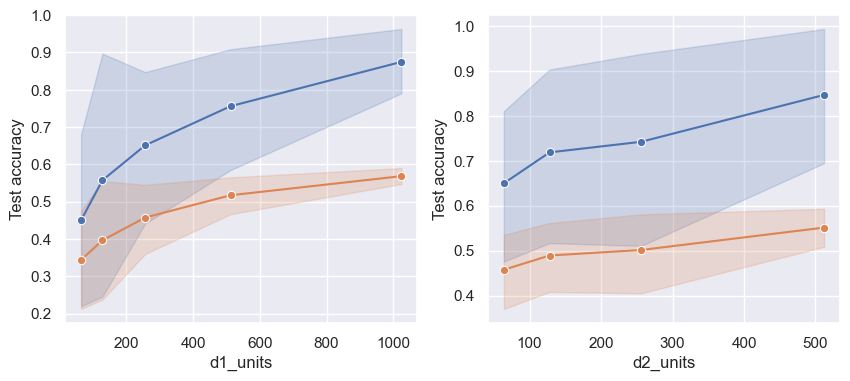

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, axs = plt.subplots(1,2,figsize=(11,4))
fig.suptitle("Best accuracy seen during training vs drop rates")

ax = axs[0]
sns.lineplot(x = drop0, y = best_train_acc, marker = 'o', ax=ax, label = 'Train')
sns.lineplot(x = drop0, y = best_val_acc, marker = 'o', ax=ax, label = 'Val')
ax.set_xlabel("drop ly_0")
ax.set_ylabel("Accuracy")
# ax.set_ylim(0.7,0.8)
ax.legend()

ax = axs[1]
sns.lineplot(x = drop1, y = best_train_acc, marker = 'o', ax=ax, label = 'Train')
sns.lineplot(x = drop1, y = best_val_acc, marker = 'o', ax=ax, label = 'Val')
ax.set_xlabel("drop ly_1")
ax.set_ylabel("Accuracy")

**Training Histories**

In [261]:
# Nepoch = 200
x_epochs = np.arange(1,Nb_epochs+1,1)
training_history = results['train_histories']

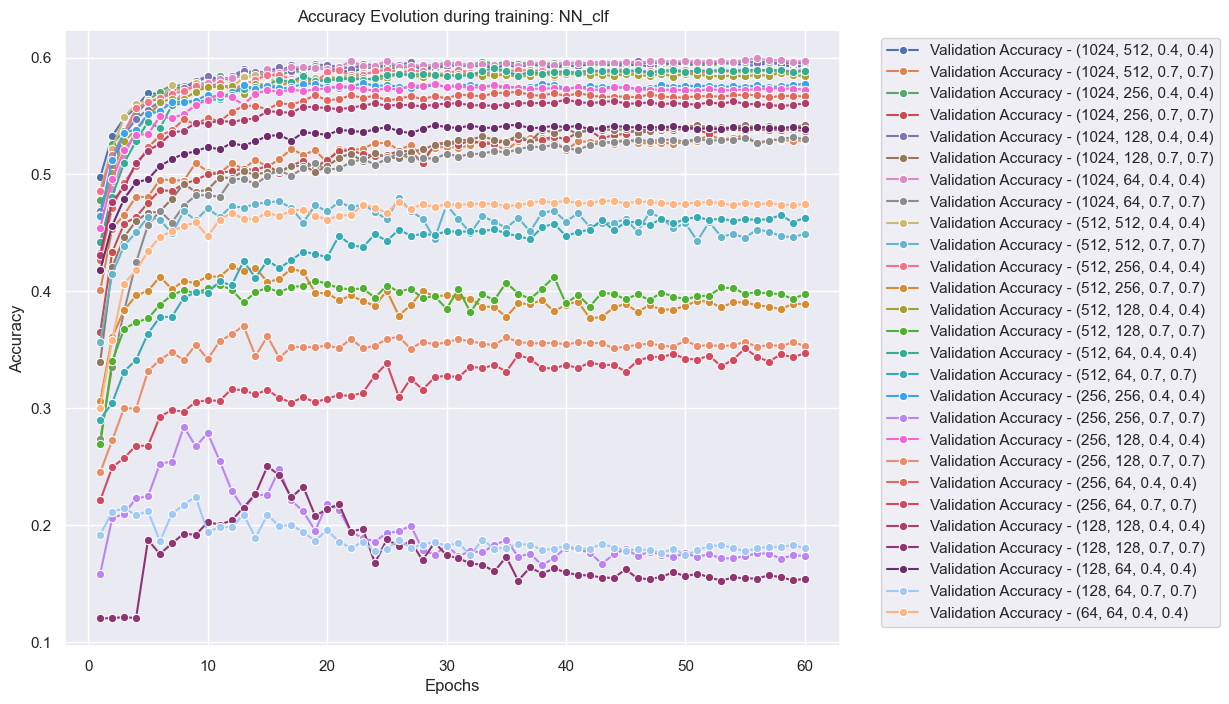

In [264]:
art1 = sns.color_palette()
art2 = sns.color_palette("husl", 9)
art3 = sns.color_palette("flare")
art4 = sns.color_palette("pastel")

art = art1 + art2 + art3 + art4

plt.figure(figsize=(10,8))

for i in range(len(training_history)-1): #len(training_history)
    
    train_acc_hist = training_history[i].history['accuracy']
    val_acc_hist = training_history[i].history['val_accuracy']
    train_loss_hist = training_history[i].history['loss']
    val_loss_hist = training_history[i].history['val_loss']

    hist_params = str(results['param_trained'][i])
    
    
    if val_acc_hist[-1] > 0.0:
        color =  art[i]
    #     sns.lineplot(x = x_epochs, y = train_acc_hist, color = color, ls = ':', label = 'Training Accuracy - ' + hist_params)
        sns.lineplot(x = x_epochs, y = val_acc_hist, color = color, marker = 'o', label = 'Validation Accuracy - ' + hist_params)
#         sns.lineplot(x = x_epochs, y = val_loss_hist, color = color, marker = 'o', label = 'Validation Loss - ' + hist_params)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution during training: NN_clf')
plt.legend(bbox_to_anchor=(1.5, 1.0))#
# plt.ylim(0.54,0.62)

**Save data into a formated dataframe**

In [246]:

results = {'param_trained' : param_trained,
           'train_histories' : train_histories,
           'accuracy_train' : acc_train,
           'accuracy_test' : acc_test,
           'loss_train' : losses_train,
           'loss_test' : losses_test}

result2 = {}
## parameter of the model trained
result2['param_trained'] = results['param_trained'] 
result2['d1_units'] = [ item[0] for item in results['param_trained']]
result2['d2_units'] = [ item[1] for item in results['param_trained']]
result2['drop1'] = [ item[2] for item in results['param_trained']]
result2['drop2'] = [ item[3] for item in results['param_trained']]

## get history metrics: accuracy and loss for train and validation set
train_acc_h = []
val_acc_h = []
train_loss_h = []
val_loss_h = []
for i in range(len(training_history)):
    
    train_acc_h.append(list(training_history[i].history['accuracy']))
    val_acc_h.append(list(training_history[i].history['val_accuracy']))
    train_loss_h.append(list(training_history[i].history['loss']))
    val_loss_h.append(list(training_history[i].history['val_loss']))
    
result2['train_acc_hist'] = train_acc_h
result2['val_acc_hist'] = val_acc_h
result2['train_loss_hist'] = train_loss_h
result2['val_loss_hist'] = val_loss_h


## get final metrics, of the best model (checkpoint tracks best val acc)
## evaluated on the train and test sets.
result2['accuracy_train_opt'] = results['accuracy_train'] 
result2['accuracy_test_opt'] = results['accuracy_test'] 
result2['loss_train_opt'] = results['loss_train'] 
result2['loss_test_opt'] = results['loss_test'] 


result2
result2_df = pd.DataFrame(result2)

In [247]:
result2_df.head()

,param_trained,d1_units,d2_units,drop1,drop2,train_acc_hist,val_acc_hist,train_loss_hist,val_loss_hist,accuracy_train_opt,accuracy_test_opt,loss_train_opt,loss_test_opt
0,"(1024, 512, 0.4, 0.4)",1024,512,0.4,0.4,"[0.3678719401359558, 0.48460760712623596, 0.52...","[0.4976080060005188, 0.5326414704322815, 0.548...","[2.2163257598876953, 1.7476418018341064, 1.582...","[1.7266384363174438, 1.5868781805038452, 1.513...",0.994719,0.596149,0.017040,2.478632
1,"(1024, 512, 0.7, 0.7)",1024,512,0.7,0.7,"[0.21784892678260803, 0.31162020564079285, 0.3...","[0.40082430839538574, 0.45322734117507935, 0.4...","[2.783543586730957, 2.3579330444335938, 2.2092...","[2.2472469806671143, 2.0069477558135986, 1.923...",0.804784,0.537211,0.756055,1.707156
2,"(1024, 256, 0.4, 0.4)",1024,256,0.4,0.4,"[0.34455791115760803, 0.46813875436782837, 0.5...","[0.47839847207069397, 0.52594393491745, 0.5374...","[2.3338818550109863, 1.8164082765579224, 1.640...","[1.7908837795257568, 1.6078319549560547, 1.546...",0.994259,0.594089,0.022637,2.325382
3,"(1024, 256, 0.7, 0.7)",1024,256,0.7,0.7,"[0.19107553362846375, 0.29101112484931946, 0.3...","[0.3648340404033661, 0.4333554208278656, 0.457...","[2.9088873863220215, 2.4615442752838135, 2.295...","[2.3216326236724854, 2.1044344902038574, 1.964...",0.767228,0.538860,0.837431,1.697886
4,"(1024, 128, 0.4, 0.4)",1024,128,0.4,0.4,"[0.2959609925746918, 0.44243261218070984, 0.49...","[0.468977689743042, 0.5061455965042114, 0.5339...","[2.53792142868042, 1.9412504434585571, 1.74302...","[1.8993116617202759, 1.7016451358795166, 1.593...",0.991425,0.600330,0.040370,2.129580


In [248]:
vggt.save(datasets = [result2_df], 
             types = ['dataframe'], 
             names = ['HeadModel_for_headlessVGG_grid_result_u1u2DropDrop'],  
              path = '../Base_models/Image_VGG/', 
              doit = False, verbose = True)

Datasets were not saved locally. Set doit = True to store them


# predictions and model

# Check the VGG output filters
* get the filter with max global averaging

In [52]:
output_vector_test.shape

(16984, 7, 7, 512)

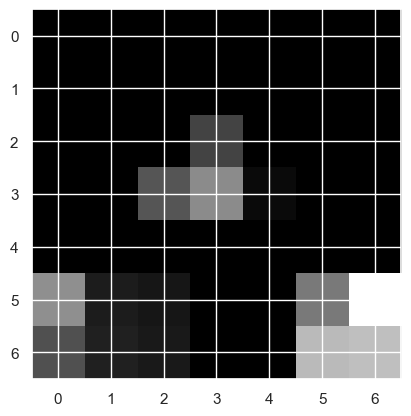

In [54]:
item = 0
kernel = 0
img = output_vector_test[item,:,:,kernel]
plt.imshow(img, cmap = 'gray')
plt.show()

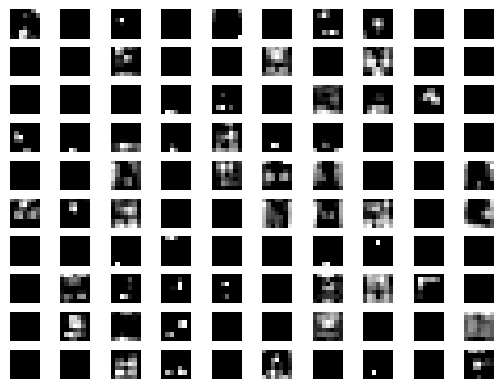

In [126]:
Nb_filters = output_vector_test.shape[-1]

j = 0
item = 0
# for i in np.random.choice(np.arange(0, Nb_filters) , size = 16):
n=0
for i in np.arange(100):
# for i in np.arange(n*36, (n+1)*36):

    j = j + 1                                # select subplot. starts from 1    
    plt.subplot(10, 10, j)    # select subplot. always define the same arrangement (2, 3, … )

    img = output_vector_train[item,:,:,i]        # image to show    
    plt.imshow(img, cmap='gray', interpolation='None')    # plot in grey scale 

#     plt.title('filter # ' + str(i), fontsize = 10)   
    plt.axis('off')       # no axis
    plt.subplots_adjust(hspace = 0.3)

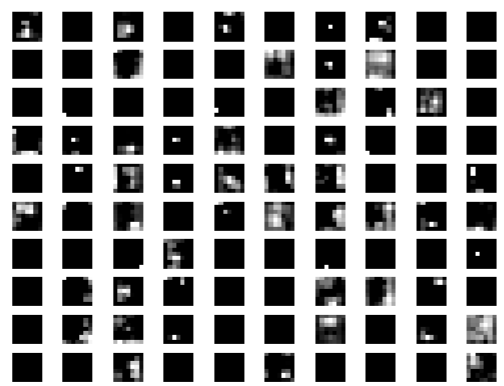

In [123]:
# output_vector_test[item,:,:,171]

In [124]:
# y_arr_train = y_train_subset['prdtypecode'].to_numpy()
# y_arr_train == 2583

In [125]:
# y_train_subset[y_train_subset['prdtypecode'] == 2583]

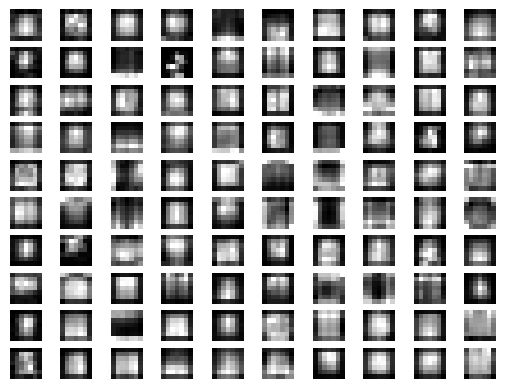

In [129]:
for i in range(100):
    t = output_vector_train[y_arr_train == 1140, :,:, i]     # all images with the same label i in range [0,9]
#     print(t.shape)
    img = t.mean(axis = 0)     #  average image, axis = 0 make the average across observation (rows) or images at each pixel. 
#     img = t.std(axis = 0)       #  To get an idea of how each image number varies in its respective category 

    plt.subplot(10, 10, i+1)     
    plt.imshow(img, cmap='gray', interpolation='None')
    plt.axis('off')

firts 100 filters of category 10 = livres_adultes 
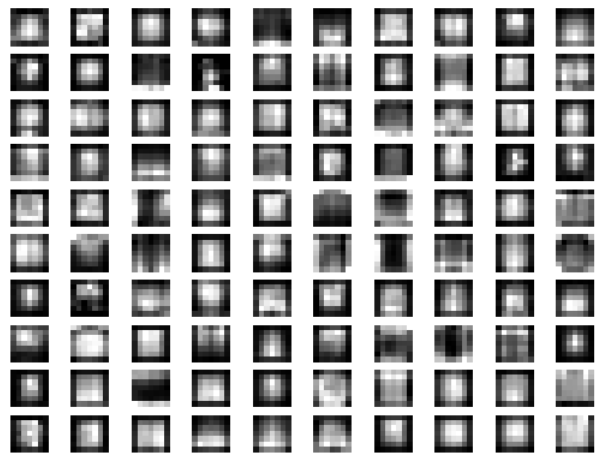